In [1]:
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import torch
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [2]:
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")          # raw images
SAM_CKPT = Path("sam/sam_vit_l_0b3195.pth")                             # downloaded weight
DEVICE   = "cuda:0" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_l"   # 'vit_h' or 'vit_b' also work (H needs >18 GB VRAM)

# Skip extremely small thumbnails (after crop they become useless)
MIN_SIDE_AFTER_CROP = 128   # pixels – set None to keep everything

# Optional JPEG quality for saved crops (higher = bigger files)
JPEG_QUALITY = 95

In [3]:
# %%
sam = sam_model_registry[MODEL_TYPE](checkpoint=str(SAM_CKPT))
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
)
print("Loaded SAM (", MODEL_TYPE, ") on", DEVICE)


/home/user1/.local/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Loaded SAM ( vit_l ) on cuda:0


In [4]:
def crop_with_mask(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 0) -> Image.Image:
    """Return the cropped RGB PIL image given a binary mask (True = fg)."""
    if mask.sum() == 0:  # empty mask – return original
        return pil_img

    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    # add padding but keep inside bounds
    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width,  x1 + pad_px)

    return pil_img.crop((x0, y0, x1, y1))


In [5]:
# Get image paths and sort by object_id
img_paths = list(SRC_DIR.rglob("*.jpg")) + list(SRC_DIR.rglob("*.jpeg"))

# Extract object_id directly from filename (before first underscore)
def get_object_id_from_filename(path):
    filename = path.stem  # filename without extension
    try:
        # Extract number before first underscore
        object_id = int(filename.split('_')[0])
        return object_id
    except (ValueError, IndexError):
        return 999999  # fallback for invalid filenames

img_paths = sorted(img_paths, key=get_object_id_from_filename)
print(f"➜Processing {len(img_paths):,} images for inscribed square cropping (sorted by object_id)")

# Print first few to verify sorting
for i, path in enumerate(img_paths[:10]):
    obj_id = get_object_id_from_filename(path)
    print(f"  {i+1:2d}. Object ID: {obj_id:5d} - {path.name}")

➜Processing 18,645 images for inscribed square cropping (sorted by object_id)
   1. Object ID: 13561 - 13561_Bed_hanging_blue-resist_textile_primary.jpg
   2. Object ID: 13562 - 13562_Bed_hanging_blue-resist_textile_primary.jpg
   3. Object ID: 13735 - 13735_Panel_blue-resist_textile_primary.jpg
   4. Object ID: 13737 - 13737_Embroidered_Picture_primary.jpg
   5. Object ID: 13740 - 13740_Embroidered_picture_of_Charles_I_primary.jpg
   6. Object ID: 13794 - 13794_Valance_blue-resist_textile_primary.jpg
   7. Object ID: 13795 - 13795_Partial_curtain_blue-resist_textile_primary.jpg
   8. Object ID: 13796 - 13796_Piece_blue-resist_textile_primary.jpg
   9. Object ID: 13798 - 13798_Piece_blue-resist_textile_primary.jpg
  10. Object ID: 13799 - 13799_Panel_blue-resist_textile_primary.jpg


In [6]:
def get_most_central_mask(masks, img_shape):
    """Select the mask whose center is closest to the image center."""
    if len(masks) == 0:
        return None
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    best_mask = None
    min_distance = float('inf')
    
    for mask_data in masks:
        mask = mask_data["segmentation"]
        
        # Find center of mass of the mask
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Calculate distance to image center
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        
        if distance < min_distance:
            min_distance = distance
            best_mask = mask_data
    
    return best_mask

def get_best_mask(masks, img_shape):
    """Select the best mask using a combination of centrality and size."""
    if len(masks) == 0:
        return None
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    best_mask = None
    best_score = -1
    
    # Find the largest mask area for normalization
    max_area = max(mask["area"] for mask in masks)
    
    for mask_data in masks:
        mask = mask_data["segmentation"]
        area = mask_data["area"]
        
        # Find center of mass of the mask
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Calculate distance to image center (normalized)
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        max_distance = np.sqrt(img_center_y**2 + img_center_x**2)  # diagonal distance
        normalized_distance = distance / max_distance
        
        # Normalize area (0 to 1)
        normalized_area = area / max_area
        
        # Combined score: prioritize central location but also consider size
        # Lower distance is better, higher area is better
        centrality_score = 1 - normalized_distance  # 1 = center, 0 = edge
        size_score = normalized_area                 # 1 = largest, 0 = smallest
        
        # Weighted combination (you can adjust these weights)
        combined_score = 0.7 * centrality_score + 0.3 * size_score
        
        if combined_score > best_score:
            best_score = combined_score
            best_mask = mask_data
    
    return best_mask

# Alternative: Multi-criteria approach
def get_smart_mask(masks, img_shape):
    """Select mask using multiple criteria with fallbacks."""
    if len(masks) == 0:
        return None
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    # Filter masks by minimum size (remove tiny segments)
    min_area = 1000  # adjust based on your images
    large_masks = [m for m in masks if m["area"] > min_area]
    
    if not large_masks:
        large_masks = masks  # fallback to all masks
    
    # Among large masks, find the most central one
    best_mask = None
    min_distance = float('inf')
    
    for mask_data in large_masks:
        mask = mask_data["segmentation"]
        
        # Find center of mass
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Distance to center
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        
        if distance < min_distance:
            min_distance = distance
            best_mask = mask_data
    
    return best_mask


In [7]:
def get_robust_mask(masks, img_shape):
    """Ultra-robust mask selection with multiple fallback strategies."""
    if len(masks) == 0:
        return None
    
    print(f"[DEBUG] Found {len(masks)} masks, selecting best one...")
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    # Strategy 1: Find masks that are reasonably sized (not tiny, not huge)
    total_pixels = img_shape[0] * img_shape[1]
    reasonable_masks = []
    
    for mask_data in masks:
        area = mask_data["area"]
        area_ratio = area / total_pixels
        
        # Keep masks that are 1-60% of image (filter out tiny specs and full background)
        if 0.01 < area_ratio < 0.6:
            reasonable_masks.append(mask_data)
    
    if not reasonable_masks:
        print("[WARN] No reasonable-sized masks found, using all masks")
        reasonable_masks = masks
    
    print(f"[DEBUG] {len(reasonable_masks)} reasonable-sized masks found")
    
    # Strategy 2: Among reasonable masks, prioritize central ones
    best_mask = None
    best_score = -1
    
    for mask_data in reasonable_masks:
        mask = mask_data["segmentation"]
        area = mask_data["area"]
        
        # Find center of mass
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Distance to image center (normalized)
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        max_distance = np.sqrt(img_center_y**2 + img_center_x**2)
        normalized_distance = distance / max_distance
        
        # Area score (normalized among reasonable masks)
        max_area = max(m["area"] for m in reasonable_masks)
        normalized_area = area / max_area
        
        # Combined score: 80% centrality, 20% size
        centrality_score = 1 - normalized_distance
        size_score = normalized_area
        combined_score = 0.8 * centrality_score + 0.2 * size_score
        
        if combined_score > best_score:
            best_score = combined_score
            best_mask = mask_data
    
    print(f"[DEBUG] Selected mask with score: {best_score:.3f}")
    return best_mask



In [8]:
def crop_everything_inside_mask_boundary(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 5) -> Image.Image:
    """Use mask as boundary - crop everything inside the mask's bounding box."""
    if mask.sum() == 0:
        return pil_img

    # Get bounding box of the mask (use mask as boundary only)
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    # Add padding but keep inside bounds
    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width, x1 + pad_px)

    # Crop EVERYTHING inside the boundary (no masking of pixels)
    return pil_img.crop((x0, y0, x1, y1))

def crop_square_from_mask_boundary(pil_img: Image.Image, mask: np.ndarray) -> Image.Image:
    """Create square crop using mask boundary - includes everything inside."""
    if mask.sum() == 0:
        # Fallback: center square of original image
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))
    
    # Get bounding box of the mask
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    
    # Calculate dimensions
    width = x1 - x0
    height = y1 - y0
    
    # Make it square by taking the larger dimension + padding
    size = max(width, height) + 40  # Add padding for safety
    
    # Center the square around the mask's center of mass
    mask_center_y = ys.mean()
    mask_center_x = xs.mean()
    
    # Calculate square bounds
    half_size = size // 2
    square_x0 = int(mask_center_x - half_size)
    square_y0 = int(mask_center_y - half_size)
    square_x1 = square_x0 + size
    square_y1 = square_y0 + size
    
    # Ensure bounds are within image
    square_x0 = max(0, square_x0)
    square_y0 = max(0, square_y0)
    square_x1 = min(pil_img.width, square_x1)
    square_y1 = min(pil_img.height, square_y1)
    
    # Return EVERYTHING inside the boundary
    return pil_img.crop((square_x0, square_y0, square_x1, square_y1))


In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import json
import pandas as pd

# New directories for both types of crops and masks
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
MASK_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")

INSCRIBED_DIR.mkdir(parents=True, exist_ok=True)
REGULAR_CROP_DIR.mkdir(parents=True, exist_ok=True)
MASK_DIR.mkdir(parents=True, exist_ok=True)

def largest_inscribed_square(mask: np.ndarray):
    """Find the largest square that fits entirely within the True region of the mask."""
    if mask.sum() == 0:
        return None
    
    # Use distance transform to find the largest inscribed square
    from scipy.ndimage import distance_transform_edt
    
    # Distance transform gives distance to nearest False pixel
    dist_transform = distance_transform_edt(mask)
    
    # Find the point with maximum distance (center of largest inscribed circle)
    max_dist = np.max(dist_transform)
    if max_dist == 0:
        return None
    
    # Find center of largest inscribed square
    center_y, center_x = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
    
    # The side length of the largest inscribed square is 2 * max_dist
    side_length = int(2 * max_dist)
    
    # Calculate square bounds
    half_side = side_length // 2
    x0 = center_x - half_side
    y0 = center_y - half_side
    x1 = x0 + side_length
    y1 = y0 + side_length
    
    return (x0, y0, x1, y1)

def crop_inscribed_square(pil_img: Image.Image, mask: np.ndarray) -> Image.Image:
    """Return the largest square crop centered on the mask centroid, fully inside the mask."""
    if mask.sum() == 0:
        # Fallback: center square of original image
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))

    # Find centroid of the mask
    ys, xs = np.where(mask)
    centroid_x = int(xs.mean())
    centroid_y = int(ys.mean())

    # Find the largest possible square centered at the centroid, fully inside the mask
    max_side = 0
    max_possible = min(
        centroid_x, mask.shape[1] - centroid_x - 1,
        centroid_y, mask.shape[0] - centroid_y - 1
    ) * 2 + 1

    for side in range(1, max_possible + 1):
        half = side // 2
        x0 = centroid_x - half
        y0 = centroid_y - half
        x1 = x0 + side
        y1 = y0 + side

        if x0 < 0 or y0 < 0 or x1 > mask.shape[1] or y1 > mask.shape[0]:
            break

        square_mask = mask[y0:y1, x0:x1]
        if square_mask.shape[0] != side or square_mask.shape[1] != side:
            break
        if np.all(square_mask):
            max_side = side
        else:
            break

    if max_side == 0:
        # Fallback: center square of original image
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))

    half = max_side // 2
    x0 = centroid_x - half
    y0 = centroid_y - half
    x1 = x0 + max_side
    y1 = y0 + max_side

    return pil_img.crop((x0, y0, x1, y1))


# Save CSV periodically and resume capability
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")

# Load existing log if available
if csv_path.exists():
    existing_df = pd.read_csv(csv_path)
    processed_files = set(existing_df['filename'].tolist())
    processing_log = existing_df.to_dict('records')
    print(f"📁 Resuming: Found {len(processed_files)} already processed files")
else:
    processed_files = set()
    processing_log = []

def crop_with_mask_only(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 5) -> Image.Image:
    """Return cropped image containing ONLY the masked region (no background)."""
    if mask.sum() == 0:
        return pil_img

    # Create a new image with transparent/white background
    result_img = Image.new('RGB', pil_img.size, (255, 255, 255))  # White background
    
    # Apply mask to original image
    img_array = np.array(pil_img)
    mask_3d = np.stack([mask, mask, mask], axis=2)  # Convert to 3-channel mask
    
    # Keep only masked pixels, rest becomes white
    masked_array = np.where(mask_3d, img_array, 255)
    masked_img = Image.fromarray(masked_array.astype(np.uint8))
    
    # Now crop to bounding box with padding
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    # Add padding but keep inside bounds
    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width, x1 + pad_px)

    return masked_img.crop((x0, y0, x1, y1))


📁 Resuming: Found 10521 already processed files


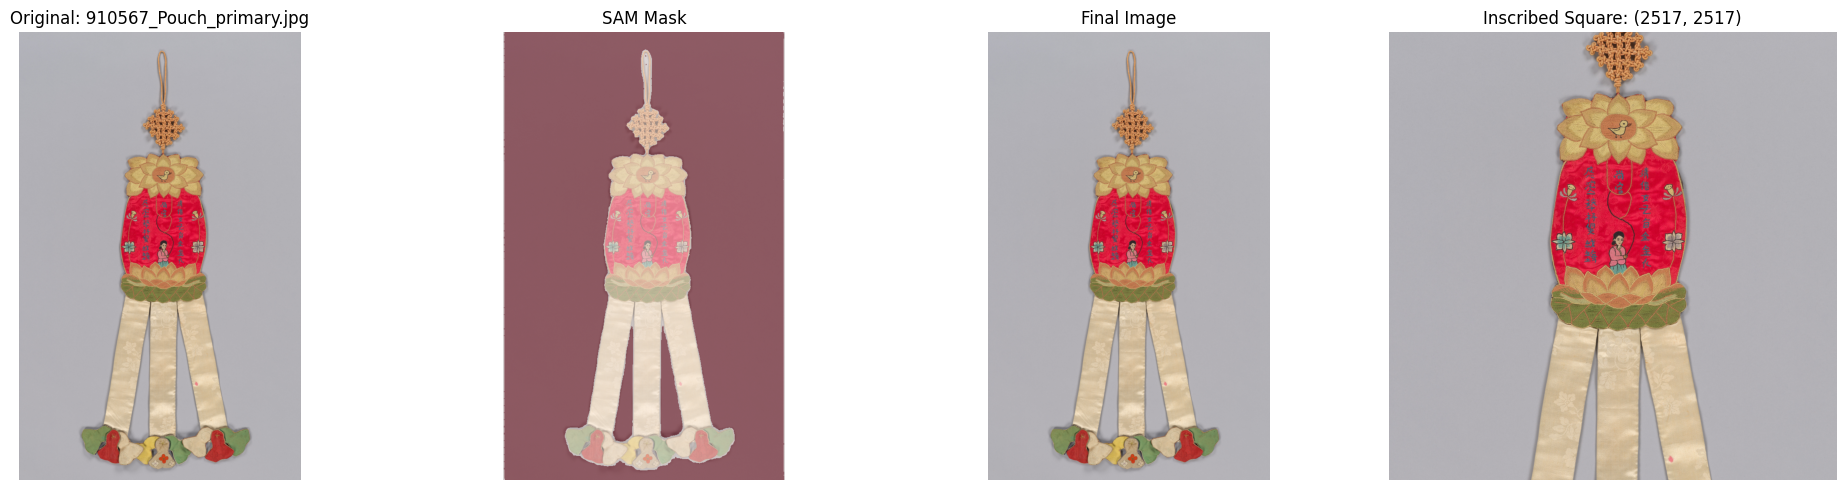

Processing: 18645/18645 - 910567_Pouch_primary.jpg
Failed so far: 0
✅ Done. Processing log saved to /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv
✅ Total processed: 17758
✅ Total errors: 51
✅ Resized images: 12438
✅ Done. Inscribed squares in /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square
✅ Done. Regular crops in /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop
✅ Done. Masks in /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png


In [10]:
print(f"➜Processing {len(img_paths):,} images (skipping {len(processed_files)} already done)")
print(f"[INFO] Starting from image {len(processed_files)} of {len(img_paths)}")
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import torch
import cv2
import shutil  # Add this line
import time   # Add this line too (for sleep in retry logic)

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
failed_count = 0
for i, path in enumerate(tqdm(img_paths, desc="Dual Cropping + Masks")):
    # Skip if already processed
    if path.name in processed_files:
        continue
    
    try:
        inscribed_path = INSCRIBED_DIR / path.relative_to(SRC_DIR)
        regular_path = REGULAR_CROP_DIR / path.relative_to(SRC_DIR)
        mask_path = MASK_DIR / path.relative_to(SRC_DIR).with_suffix('.png')
        
        inscribed_path.parent.mkdir(parents=True, exist_ok=True)
        regular_path.parent.mkdir(parents=True, exist_ok=True)
        mask_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            img = Image.open(path).convert("RGB")
            original_size = img.size
        except Exception as e:
            print(f"[WARN] Cannot open {path}: {e}")
            continue

        # Memory management
        if i % 50 == 0:
            torch.cuda.empty_cache()
            import gc
            gc.collect()
            
        # Check disk space every 100 images
        if i % 100 == 0:
            _, _, free = shutil.disk_usage(INSCRIBED_DIR)
            if free < 1_000_000_000:  # Less than 1GB
                print(f"[ERROR] Low disk space ({free/1e9:.1f}GB). Stopping.")
                break

        # SAM processing with retry
        img_np = np.array(img)
        was_resized = False
        max_size = 1024
        
        if max(img_np.shape[:2]) > max_size:
            scale = max_size / max(img_np.shape[:2])
            new_width = int(img_np.shape[1] * scale)
            new_height = int(img_np.shape[0] * scale)
            img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            was_resized = True
        
        # SAM with retry logic
        masks = []
        for sam_attempt in range(3):  # Try up to 3 times
            try:
                torch.cuda.empty_cache()
                with torch.no_grad():
                    masks = mask_generator.generate(img_np)
                break
            except Exception as sam_error:
                print(f"[WARN] SAM attempt {sam_attempt+1} failed: {sam_error}")
                if sam_attempt == 2:  # Last attempt
                    print(f"[ERROR] SAM failed on {path.name} after 3 attempts")
                    masks = []
                torch.cuda.empty_cache()
                time.sleep(1)
        
        # Process masks and create crops
        if len(masks) == 0:
            inscribed_crop = img
            regular_crop = img
            main_mask = None
            mask_area = 0
        else:
            best_mask_data = max(masks, key=lambda m: m["area"])
            main_mask = best_mask_data["segmentation"]
            mask_area = best_mask_data["area"]
            
            if was_resized:
                mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
                mask_img = mask_img.resize(original_size, Image.Resampling.NEAREST)
                main_mask = np.array(mask_img) > 128
            
            inscribed_crop = crop_inscribed_square(img, main_mask)
            regular_crop = crop_everything_inside_mask_boundary(img, main_mask, pad_px=10)

        # Log processing details
        log_entry = {
            'filename': path.name,
            'object_id': get_object_id_from_filename(path),
            'original_size': f"{original_size[0]}x{original_size[1]}",
            'was_resized': was_resized,
            'num_masks': len(masks),
            'mask_area': mask_area,
            'inscribed_size': f"{inscribed_crop.size[0]}x{inscribed_crop.size[1]}",
            'regular_size': f"{regular_crop.size[0]}x{regular_crop.size[1]}",
            'status': 'processed'
        }
        processing_log.append(log_entry)

        # Skip very small crops
        if MIN_SIDE_AFTER_CROP and (min(inscribed_crop.size) < MIN_SIDE_AFTER_CROP or min(regular_crop.size) < MIN_SIDE_AFTER_CROP):
            log_entry['status'] = 'skipped_too_small'
            continue

        # Save outputs
        inscribed_crop.save(inscribed_path, quality=JPEG_QUALITY)
        regular_crop.save(regular_path, quality=JPEG_QUALITY)
        
        if main_mask is not None:
            mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
            mask_img.save(mask_path)

        # More frequent saves
        if i % 5 == 0:
            df = pd.DataFrame(processing_log)
            df.to_csv(csv_path, index=False)
            
        # Backup every 100 images
        if i % 100 == 0:
            backup_path = csv_path.with_name(f"processing_log_backup_{i}.csv")
            df = pd.DataFrame(processing_log)
            df.to_csv(backup_path, index=False)
            
        # Less frequent visualization to save memory
        if i % 20 == 0 or i >= len(img_paths) - 5:
            clear_output(wait=True)
            
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            axes[0].imshow(img)
            axes[0].set_title(f"Original: {path.name}")
            axes[0].axis('off')
            
            if main_mask is not None:
                axes[1].imshow(img)
                axes[1].imshow(main_mask, alpha=0.5, cmap='Reds')
                axes[1].set_title("SAM Mask")
            else:
                axes[1].imshow(img)
                axes[1].set_title("No mask found")
            axes[1].axis('off')
            
            axes[2].imshow(regular_crop)
            axes[2].set_title(f"Final Image")
            axes[2].axis('off')
            
            axes[3].imshow(inscribed_crop)
            axes[3].set_title(f"Inscribed Square: {inscribed_crop.size}")
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()
            plt.close('all')  # Free memory
            
            print(f"Processing: {i+1}/{len(img_paths)} - {path.name}")
            print(f"Failed so far: {failed_count}")

    except Exception as e:
        failed_count += 1
        print(f"[ERROR] Failed to process {path.name}: {e}")
        log_entry = {
            'filename': path.name,
            'object_id': get_object_id_from_filename(path),
            'original_size': 'unknown',
            'was_resized': False,
            'num_masks': 0,
            'mask_area': 0,
            'inscribed_size': 'error',
            'regular_size': 'error',
            'status': f'error: {str(e)[:100]}'
        }
        processing_log.append(log_entry)
        
        # If too many failures, stop
        if failed_count > 50:
            print(f"[ERROR] Too many failures ({failed_count}). Stopping.")
            break
        
        # Clean up and continue
        torch.cuda.empty_cache()
        continue

# Final save with summary
df = pd.DataFrame(processing_log)
df.to_csv(csv_path, index=False)

print(f"✅ Done. Processing log saved to {csv_path}")
print(f"✅ Total processed: {len(df[df['status'] == 'processed'])}")
print(f"✅ Total errors: {len(df[df['status'].str.contains('error', na=False)])}")
print(f"✅ Resized images: {df['was_resized'].sum()}")
print(f"✅ Done. Inscribed squares in {INSCRIBED_DIR}")
print(f"✅ Done. Regular crops in {REGULAR_CROP_DIR}")
print(f"✅ Done. Masks in {MASK_DIR}")

In [15]:
import pandas as pd

# Load the processing log
df = pd.read_csv('/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv')

# Overall statistics
print("📊 PROCESSING SUMMARY")
print("=" * 50)
print(f"Total images processed: {len(df):,}")
print()

# Status breakdown
status_counts = df['status'].value_counts()
print("📈 STATUS BREAKDOWN:")
for status, count in status_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")
print()

# Success rate
successful = len(df[df['status'] == 'processed'])
success_rate = (successful / len(df)) * 100
print(f"✅ SUCCESS RATE: {success_rate:.1f}% ({successful:,} out of {len(df):,})")
print()

# Failures analysis
failed_df = df[df['status'].str.contains('error', na=False)]
skipped_df = df[df['status'] == 'skipped_too_small']

print("⚠️  FAILURES & ISSUES:")
print(f"  Errors: {len(failed_df):,}")
print(f"  Skipped (too small): {len(skipped_df):,}")
print()

# Show some error examples if any
if len(failed_df) > 0:
    print("🔍 SAMPLE ERROR CASES:")
    for i, row in failed_df.head(5).iterrows():
        print(f"  {row['filename']}: {row['status']}")
    print()

# Resizing statistics
resized_count = df['was_resized'].sum()
print(f"📏 RESIZING STATS:")
print(f"  Images resized: {resized_count:,} ({(resized_count/len(df)*100):.1f}%)")
print()

# Mask statistics
mask_stats = df[df['status'] == 'processed']['num_masks'].describe()
print(f"🎭 MASK STATISTICS (successful only):")
print(f"  Average masks per image: {mask_stats['mean']:.1f}")
print(f"  Min masks: {mask_stats['min']:.0f}")
print(f"  Max masks: {mask_stats['max']:.0f}")
print()

# Size analysis
print("📐 SIZE ANALYSIS:")
successful_df = df[df['status'] == 'processed']
print(f"  Images with inscribed squares: {len(successful_df):,}")
print(f"  Images with regular crops: {len(successful_df):,}")

📊 PROCESSING SUMMARY
Total images processed: 18,757

📈 STATUS BREAKDOWN:
  processed: 17,808 (94.9%)
  skipped_too_small: 949 (5.1%)

✅ SUCCESS RATE: 94.9% (17,808 out of 18,757)

⚠️  FAILURES & ISSUES:
  Errors: 0
  Skipped (too small): 949

📏 RESIZING STATS:
  Images resized: 12,469 (66.5%)

🎭 MASK STATISTICS (successful only):
  Average masks per image: 97.5
  Min masks: 1
  Max masks: 742

📐 SIZE ANALYSIS:
  Images with inscribed squares: 17,808
  Images with regular crops: 17,808


In [14]:
import pandas as pd
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import torch
import cv2
import shutil  # This was missing!
import time

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the processing log to find failed images
df = pd.read_csv('/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv')
failed_df = df[df['status'].str.contains('error', na=False)]

print(f"📋 Found {len(failed_df)} failed images to reprocess")
print("Failed images:")
for i, row in failed_df.iterrows():
    print(f"  {row['filename']}")

# Get the failed filenames
failed_filenames = set(failed_df['filename'].tolist())

# Setup paths and directories
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
MASK_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")

# Find the actual image paths for failed files
img_paths = list(SRC_DIR.rglob("*.jpg")) + list(SRC_DIR.rglob("*.jpeg"))
failed_paths = [p for p in img_paths if p.name in failed_filenames]

print(f"\n🔄 Processing {len(failed_paths)} failed images...")

# Load existing processing log
processing_log = df.to_dict('records')

# Remove failed entries from log (we'll add them back with correct status)
processing_log = [entry for entry in processing_log if entry['filename'] not in failed_filenames]

def get_object_id_from_filename(path):
    filename = path.stem
    try:
        object_id = int(filename.split('_')[0])
        return object_id
    except (ValueError, IndexError):
        return 999999

# Your existing functions (copy from above)
def crop_everything_inside_mask_boundary(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 5) -> Image.Image:
    """Use mask as boundary - crop everything inside the mask's bounding box."""
    if mask.sum() == 0:
        return pil_img

    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width, x1 + pad_px)

    return pil_img.crop((x0, y0, x1, y1))

def crop_inscribed_square(pil_img: Image.Image, mask: np.ndarray) -> Image.Image:
    """Return the largest square crop centered on the mask centroid, fully inside the mask."""
    if mask.sum() == 0:
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))

    ys, xs = np.where(mask)
    centroid_x = int(xs.mean())
    centroid_y = int(ys.mean())

    max_side = 0
    max_possible = min(
        centroid_x, mask.shape[1] - centroid_x - 1,
        centroid_y, mask.shape[0] - centroid_y - 1
    ) * 2 + 1

    for side in range(1, max_possible + 1):
        half = side // 2
        x0 = centroid_x - half
        y0 = centroid_y - half
        x1 = x0 + side
        y1 = y0 + side

        if x0 < 0 or y0 < 0 or x1 > mask.shape[1] or y1 > mask.shape[0]:
            break

        square_mask = mask[y0:y1, x0:x1]
        if square_mask.shape[0] != side or square_mask.shape[1] != side:
            break
        if np.all(square_mask):
            max_side = side
        else:
            break

    if max_side == 0:
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))

    half = max_side // 2
    x0 = centroid_x - half
    y0 = centroid_y - half
    x1 = x0 + max_side
    y1 = y0 + max_side

    return pil_img.crop((x0, y0, x1, y1))

# Process failed images
failed_count = 0
successful_count = 0

for i, path in enumerate(tqdm(failed_paths, desc="Reprocessing Failed Images")):
    try:
        inscribed_path = INSCRIBED_DIR / path.relative_to(SRC_DIR)
        regular_path = REGULAR_CROP_DIR / path.relative_to(SRC_DIR)
        mask_path = MASK_DIR / path.relative_to(SRC_DIR).with_suffix('.png')
        
        inscribed_path.parent.mkdir(parents=True, exist_ok=True)
        regular_path.parent.mkdir(parents=True, exist_ok=True)
        mask_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            img = Image.open(path).convert("RGB")
            original_size = img.size
        except Exception as e:
            print(f"[WARN] Cannot open {path}: {e}")
            continue

        # Memory management
        if i % 10 == 0:
            torch.cuda.empty_cache()
            import gc
            gc.collect()

        # SAM processing
        img_np = np.array(img)
        was_resized = False
        max_size = 1024
        
        if max(img_np.shape[:2]) > max_size:
            scale = max_size / max(img_np.shape[:2])
            new_width = int(img_np.shape[1] * scale)
            new_height = int(img_np.shape[0] * scale)
            img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            was_resized = True
        
        # SAM with retry logic
        masks = []
        for sam_attempt in range(3):
            try:
                torch.cuda.empty_cache()
                with torch.no_grad():
                    masks = mask_generator.generate(img_np)
                break
            except Exception as sam_error:
                print(f"[WARN] SAM attempt {sam_attempt+1} failed: {sam_error}")
                if sam_attempt == 2:
                    print(f"[ERROR] SAM failed on {path.name} after 3 attempts")
                    masks = []
                torch.cuda.empty_cache()
                time.sleep(1)
        
        # Process masks and create crops
        if len(masks) == 0:
            inscribed_crop = img
            regular_crop = img
            main_mask = None
            mask_area = 0
        else:
            best_mask_data = max(masks, key=lambda m: m["area"])
            main_mask = best_mask_data["segmentation"]
            mask_area = best_mask_data["area"]
            
            if was_resized:
                mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
                mask_img = mask_img.resize(original_size, Image.Resampling.NEAREST)
                main_mask = np.array(mask_img) > 128
            
            inscribed_crop = crop_inscribed_square(img, main_mask)
            regular_crop = crop_everything_inside_mask_boundary(img, main_mask, pad_px=10)

        # Log processing details
        log_entry = {
            'filename': path.name,
            'object_id': get_object_id_from_filename(path),
            'original_size': f"{original_size[0]}x{original_size[1]}",
            'was_resized': was_resized,
            'num_masks': len(masks),
            'mask_area': mask_area,
            'inscribed_size': f"{inscribed_crop.size[0]}x{inscribed_crop.size[1]}",
            'regular_size': f"{regular_crop.size[0]}x{regular_crop.size[1]}",
            'status': 'processed'
        }

        # Skip very small crops
        MIN_SIDE_AFTER_CROP = 128
        if MIN_SIDE_AFTER_CROP and (min(inscribed_crop.size) < MIN_SIDE_AFTER_CROP or min(regular_crop.size) < MIN_SIDE_AFTER_CROP):
            log_entry['status'] = 'skipped_too_small'
            processing_log.append(log_entry)
            continue

        # Save outputs
        JPEG_QUALITY = 95
        inscribed_crop.save(inscribed_path, quality=JPEG_QUALITY)
        regular_crop.save(regular_path, quality=JPEG_QUALITY)
        
        if main_mask is not None:
            mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
            mask_img.save(mask_path)

        processing_log.append(log_entry)
        successful_count += 1
        
        print(f"✅ Successfully processed {path.name}")

    except Exception as e:
        failed_count += 1
        print(f"[ERROR] Failed to process {path.name}: {e}")
        log_entry = {
            'filename': path.name,
            'object_id': get_object_id_from_filename(path),
            'original_size': 'unknown',
            'was_resized': False,
            'num_masks': 0,
            'mask_area': 0,
            'inscribed_size': 'error',
            'regular_size': 'error',
            'status': f'error: {str(e)[:100]}'
        }
        processing_log.append(log_entry)
        torch.cuda.empty_cache()
        continue

# Save updated log
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")
df_updated = pd.DataFrame(processing_log)
df_updated.to_csv(csv_path, index=False)

print(f"\n✅ REPROCESSING COMPLETE:")
print(f"   Successfully processed: {successful_count}")
print(f"   Still failed: {failed_count}")
print(f"   Updated log saved to: {csv_path}")

# Print final stats
print(f"\n📊 FINAL STATISTICS:")
final_df = pd.DataFrame(processing_log)
final_status = final_df['status'].value_counts()
for status, count in final_status.items():
    percentage = (count / len(final_df)) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

📋 Found 51 failed images to reprocess
Failed images:
  13561_Bed_hanging_blue-resist_textile_primary.jpg
  44120_Panel_Kesi_with_a_Phoenix_and_Other_Birds_primary.jpg
  53664_Textile_primary.jpg
  61868_Textile_with_deer_and_a_woven_inscription_primary.jpg
  65714_Hanging_primary.jpg
  65852_Piece_primary.jpg
  65953_Piece_primary.jpg
  66057_Piece_primary.jpg
  66161_Piece_primary.jpg
  66262_Piece_primary.jpg
  66364_Piece_primary.jpg
  66468_Piece_primary.jpg
  66569_Piece_primary.jpg
  66670_Piece_primary.jpg
  66772_Piece_primary.jpg
  66872_Piece_primary.jpg
  66974_Piece_primary.jpg
  67076_Piece_primary.jpg
  67177_Piece_primary.jpg
  67285_Piece_primary.jpg
  67387_Piece_primary.jpg
  67489_Piece_primary.jpg
  67591_Piece_primary.jpg
  67700_Piece_primary.jpg
  67804_Piece_primary.jpg
  67922_Piece_primary.jpg
  68025_Textile_primary.jpg
  68127_Textile_Sample_from_Sample_Book_primary.jpg
  68228_Textile_Sample_from_Sample_Book_primary.jpg
  68336_Priests_Robe_Shichijō_primary

Reprocessing Failed Images:   0%|          | 0/51 [00:00<?, ?it/s]

✅ Successfully processed 66569_Piece_primary.jpg
✅ Successfully processed 70276_Hanging_primary.jpg
✅ Successfully processed 71185_Piece_primary.jpg
✅ Successfully processed 68441_Rug_primary.jpg
✅ Successfully processed 66872_Piece_primary.jpg
✅ Successfully processed 53664_Textile_primary.jpg
✅ Successfully processed 65852_Piece_primary.jpg
✅ Successfully processed 70411_Piece_primary.jpg
✅ Successfully processed 68228_Textile_Sample_from_Sample_Book_primary.jpg
✅ Successfully processed 71428_Piece_primary.jpg
✅ Successfully processed 68828_Fan_Holder_primary.jpg
✅ Successfully processed 66364_Piece_primary.jpg
✅ Successfully processed 71077_Piece_primary.jpg
✅ Successfully processed 67489_Piece_primary.jpg
✅ Successfully processed 61868_Textile_with_deer_and_a_woven_inscription_primary.jpg
✅ Successfully processed 69607_Fragment_primary.jpg
✅ Successfully processed 68025_Textile_primary.jpg
✅ Successfully processed 70797_Canopy_for_Holy_Place_primary.jpg
✅ Successfully processed 441

In [16]:
import pandas as pd
from pathlib import Path
import os

# Define all paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
MASKS_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")
CSV_PATH = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")

print("🔍 COMPREHENSIVE PROCESSING ANALYSIS")
print("=" * 60)

# 1. Count original images
if SRC_DIR.exists():
    original_images = list(SRC_DIR.rglob("*.jpg")) + list(SRC_DIR.rglob("*.jpeg"))
    print(f"📁 Original images in source: {len(original_images):,}")
else:
    print("❌ Source directory not found!")
    original_images = []

# 2. Count files in each output directory
if MASKS_DIR.exists():
    mask_files = list(MASKS_DIR.rglob("*.png"))
    print(f"🎭 Mask files generated: {len(mask_files):,}")
else:
    print("❌ Masks directory not found!")
    mask_files = []

if REGULAR_CROP_DIR.exists():
    regular_crop_files = list(REGULAR_CROP_DIR.rglob("*.jpg"))
    print(f"✂️  Regular crop files: {len(regular_crop_files):,}")
else:
    print("❌ Regular crop directory not found!")
    regular_crop_files = []

if INSCRIBED_DIR.exists():
    inscribed_files = list(INSCRIBED_DIR.rglob("*.jpg"))
    print(f"🔲 Inscribed square files: {len(inscribed_files):,}")
else:
    print("❌ Inscribed directory not found!")
    inscribed_files = []

print()

# 3. Analyze CSV log
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    print(f"📊 CSV LOG ANALYSIS:")
    print(f"   Total entries in CSV: {len(df):,}")
    
    # Status breakdown
    status_counts = df['status'].value_counts()
    print(f"\n   Status breakdown:")
    for status, count in status_counts.items():
        percentage = (count / len(df)) * 100
        print(f"     {status}: {count:,} ({percentage:.1f}%)")
    
    # Check for duplicates
    duplicates = df['filename'].duplicated().sum()
    print(f"\n   Duplicate entries in CSV: {duplicates:,}")
    
    if duplicates > 0:
        print("   Duplicate filenames:")
        dup_files = df[df['filename'].duplicated(keep=False)]['filename'].unique()
        for dup in dup_files[:10]:  # Show first 10
            print(f"     {dup}")
        if len(dup_files) > 10:
            print(f"     ... and {len(dup_files)-10} more")
    
else:
    print("❌ CSV log not found!")
    df = pd.DataFrame()

print("\n" + "=" * 60)
print("🔢 COUNT VERIFICATION:")

# 4. Check if counts match
if not df.empty:
    processed_count = len(df[df['status'] == 'processed'])
    skipped_count = len(df[df['status'] == 'skipped_too_small'])
    error_count = len(df[df['status'].str.contains('error', na=False)])
    
    print(f"📈 CSV Summary:")
    print(f"   Successfully processed: {processed_count:,}")
    print(f"   Skipped (too small): {skipped_count:,}")
    print(f"   Errors: {error_count:,}")
    print(f"   Total in CSV: {len(df):,}")
    
    print(f"\n📁 File Counts:")
    print(f"   Original images: {len(original_images):,}")
    print(f"   Mask files: {len(mask_files):,}")
    print(f"   Regular crops: {len(regular_crop_files):,}")
    print(f"   Inscribed squares: {len(inscribed_files):,}")
    
    # Check consistency
    print(f"\n✅ CONSISTENCY CHECK:")
    csv_vs_original = len(df) == len(original_images)
    masks_vs_processed = len(mask_files) == processed_count
    crops_vs_processed = len(regular_crop_files) == processed_count
    inscribed_vs_processed = len(inscribed_files) == processed_count
    
    print(f"   CSV entries = Original images: {csv_vs_original} ({len(df)} = {len(original_images)})")
    print(f"   Mask files = Processed count: {masks_vs_processed} ({len(mask_files)} = {processed_count})")
    print(f"   Regular crops = Processed count: {crops_vs_processed} ({len(regular_crop_files)} = {processed_count})")
    print(f"   Inscribed squares = Processed count: {inscribed_vs_processed} ({len(inscribed_files)} = {processed_count})")
    
    if all([csv_vs_original, masks_vs_processed, crops_vs_processed, inscribed_vs_processed]):
        print("\n🎉 PERFECT! All counts match exactly!")
    else:
        print("\n⚠️  DISCREPANCIES FOUND!")
        
        # Detailed analysis of discrepancies
        if not csv_vs_original:
            print(f"   Missing from CSV: {len(original_images) - len(df)} images")
        
        if not masks_vs_processed:
            print(f"   Mask file discrepancy: {abs(len(mask_files) - processed_count)} files")
        
        if not crops_vs_processed:
            print(f"   Regular crop discrepancy: {abs(len(regular_crop_files) - processed_count)} files")
        
        if not inscribed_vs_processed:
            print(f"   Inscribed square discrepancy: {abs(len(inscribed_files) - processed_count)} files")

print("\n" + "=" * 60)

🔍 COMPREHENSIVE PROCESSING ANALYSIS
📁 Original images in source: 18,645
🎭 Mask files generated: 17,696
✂️  Regular crop files: 17,696
🔲 Inscribed square files: 17,696

📊 CSV LOG ANALYSIS:
   Total entries in CSV: 18,757

   Status breakdown:
     processed: 17,808 (94.9%)
     skipped_too_small: 949 (5.1%)

   Duplicate entries in CSV: 113
   Duplicate filenames:
     216877_Piece_primary.jpg
     216879_Piece_primary.jpg
     216880_Piece_primary.jpg
     216881_Piece_primary.jpg
     216882_Piece_primary.jpg
     216883_Piece_primary.jpg
     216884_Piece_primary.jpg
     216886_Piece_primary.jpg
     216887_Piece_primary.jpg
     216888_Piece_primary.jpg
     ... and 103 more

🔢 COUNT VERIFICATION:
📈 CSV Summary:
   Successfully processed: 17,808
   Skipped (too small): 949
   Errors: 0
   Total in CSV: 18,757

📁 File Counts:
   Original images: 18,645
   Mask files: 17,696
   Regular crops: 17,696
   Inscribed squares: 17,696

✅ CONSISTENCY CHECK:
   CSV entries = Original images: 

In [17]:
# 5. Handle skipped files (copy originals to output directories)
if not df.empty:
    skipped_df = df[df['status'] == 'skipped_too_small']
    
    if len(skipped_df) > 0:
        print(f"🔄 HANDLING {len(skipped_df)} SKIPPED FILES:")
        print("   These were skipped but should be copied to output directories...")
        
        import shutil
        copied_masks = 0
        copied_regular = 0
        copied_inscribed = 0
        
        for _, row in skipped_df.iterrows():
            filename = row['filename']
            
            # Find original file
            original_file = None
            for img_path in original_images:
                if img_path.name == filename:
                    original_file = img_path
                    break
            
            if original_file and original_file.exists():
                try:
                    # Create output paths
                    mask_output = MASKS_DIR / original_file.relative_to(SRC_DIR).with_suffix('.png')
                    regular_output = REGULAR_CROP_DIR / original_file.relative_to(SRC_DIR)
                    inscribed_output = INSCRIBED_DIR / original_file.relative_to(SRC_DIR)
                    
                    # Create directories
                    mask_output.parent.mkdir(parents=True, exist_ok=True)
                    regular_output.parent.mkdir(parents=True, exist_ok=True)
                    inscribed_output.parent.mkdir(parents=True, exist_ok=True)
                    
                    # Copy original to regular and inscribed (since no processing was done)
                    if not regular_output.exists():
                        shutil.copy2(original_file, regular_output)
                        copied_regular += 1
                    
                    if not inscribed_output.exists():
                        shutil.copy2(original_file, inscribed_output)
                        copied_inscribed += 1
                    
                    # Create a blank mask (white image same size as original)
                    if not mask_output.exists():
                        from PIL import Image
                        img = Image.open(original_file)
                        blank_mask = Image.new('L', img.size, 255)  # White mask
                        blank_mask.save(mask_output)
                        copied_masks += 1
                        
                except Exception as e:
                    print(f"     Error copying {filename}: {e}")
            else:
                print(f"     Original file not found: {filename}")
        
        print(f"   ✅ Copied {copied_regular} files to regular_crop")
        print(f"   ✅ Copied {copied_inscribed} files to inscribed_square")
        print(f"   ✅ Created {copied_masks} blank masks")
    else:
        print("✅ No skipped files to handle!")

print("\n" + "=" * 60)

🔄 HANDLING 949 SKIPPED FILES:
   These were skipped but should be copied to output directories...
   ✅ Copied 948 files to regular_crop
   ✅ Copied 948 files to inscribed_square
   ✅ Created 948 blank masks



In [18]:
# 6. Final verification after handling skipped files
print("🔍 FINAL VERIFICATION (after handling skipped files):")

# Recount files
if MASKS_DIR.exists():
    final_mask_files = list(MASKS_DIR.rglob("*.png"))
    print(f"🎭 Final mask files: {len(final_mask_files):,}")

if REGULAR_CROP_DIR.exists():
    final_regular_files = list(REGULAR_CROP_DIR.rglob("*.jpg"))
    print(f"✂️  Final regular crop files: {len(final_regular_files):,}")

if INSCRIBED_DIR.exists():
    final_inscribed_files = list(INSCRIBED_DIR.rglob("*.jpg"))
    print(f"🔲 Final inscribed files: {len(final_inscribed_files):,}")

if not df.empty:
    # Should now equal: processed + skipped (excluding errors)
    expected_files = len(df[df['status'].isin(['processed', 'skipped_too_small'])])
    
    print(f"\n📊 EXPECTED vs ACTUAL:")
    print(f"   Expected files (processed + skipped): {expected_files:,}")
    print(f"   Actual mask files: {len(final_mask_files):,}")
    print(f"   Actual regular crops: {len(final_regular_files):,}")
    print(f"   Actual inscribed squares: {len(final_inscribed_files):,}")
    
    all_match = (len(final_mask_files) == expected_files and 
                 len(final_regular_files) == expected_files and 
                 len(final_inscribed_files) == expected_files)
    
    if all_match:
        print(f"\n🎉 PERFECT FINAL STATE!")
        print(f"   All output directories have exactly {expected_files:,} files")
        print(f"   Original directory: {len(original_images):,} images")
        print(f"   CSV entries: {len(df):,} rows")
        print(f"   Success rate: {(expected_files/len(original_images)*100):.1f}%")
    else:
        print(f"\n⚠️  FINAL DISCREPANCIES STILL EXIST!")

print("\n" + "🎯" * 20)
print("PROCESSING ANALYSIS COMPLETE!")
print("🎯" * 20)

🔍 FINAL VERIFICATION (after handling skipped files):
🎭 Final mask files: 18,644
✂️  Final regular crop files: 18,644
🔲 Final inscribed files: 18,644

📊 EXPECTED vs ACTUAL:
   Expected files (processed + skipped): 18,757
   Actual mask files: 18,644
   Actual regular crops: 18,644
   Actual inscribed squares: 18,644

⚠️  FINAL DISCREPANCIES STILL EXIST!

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
PROCESSING ANALYSIS COMPLETE!
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯


In [19]:
import pandas as pd
from pathlib import Path

# Load the CSV and analyze duplicates
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")
df = pd.read_csv(csv_path)

print("🔍 DUPLICATE ANALYSIS")
print("=" * 50)

# Find all duplicates
duplicates = df[df['filename'].duplicated(keep=False)]
print(f"Total duplicate entries: {len(duplicates)}")

# Group by filename to see how many times each appears
duplicate_counts = duplicates['filename'].value_counts()
print(f"Number of unique filenames with duplicates: {len(duplicate_counts)}")

print("\nDuplicate breakdown:")
for filename, count in duplicate_counts.head(10).items():
    print(f"  {filename}: {count} times")

# Check if duplicates have different statuses
print("\nDuplicate status analysis:")
for filename in duplicate_counts.head(5).index:
    file_entries = df[df['filename'] == filename]
    statuses = file_entries['status'].unique()
    print(f"  {filename}: {statuses}")

print("\n" + "=" * 50)

🔍 DUPLICATE ANALYSIS
Total duplicate entries: 226
Number of unique filenames with duplicates: 113

Duplicate breakdown:
  216877_Piece_primary.jpg: 2 times
  216958_Piece_primary.jpg: 2 times
  216993_Cap_crown_primary.jpg: 2 times
  216991_Fragment_primary.jpg: 2 times
  216990_Scapular__one_of_a_pair_primary.jpg: 2 times
  216989_Scapular__one_of_a_pair_primary.jpg: 2 times
  216988_Chalice_Veil_primary.jpg: 2 times
  216987_Fragment_primary.jpg: 2 times
  216986_Cap_band_primary.jpg: 2 times
  216984_Piece_primary.jpg: 2 times

Duplicate status analysis:
  216877_Piece_primary.jpg: ['processed']
  216958_Piece_primary.jpg: ['processed']
  216993_Cap_crown_primary.jpg: ['processed']
  216991_Fragment_primary.jpg: ['processed']
  216990_Scapular__one_of_a_pair_primary.jpg: ['processed']



In [20]:
# Remove duplicates - keep the LAST entry for each filename (most recent processing)
print("🧹 CLEANING DUPLICATES")
print("=" * 50)

print(f"Before cleaning: {len(df)} entries")

# Remove duplicates, keeping the last occurrence
df_clean = df.drop_duplicates(subset=['filename'], keep='last')

print(f"After cleaning: {len(df_clean)} entries")
print(f"Duplicates removed: {len(df) - len(df_clean)}")

# Check the cleaned data
status_counts = df_clean['status'].value_counts()
print(f"\nCleaned data status breakdown:")
for status, count in status_counts.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

# Save the cleaned CSV
backup_path = csv_path.with_name("processing_log_with_duplicates.csv")
df.to_csv(backup_path, index=False)
print(f"\n✅ Original CSV backed up to: {backup_path}")

df_clean.to_csv(csv_path, index=False)
print(f"✅ Cleaned CSV saved to: {csv_path}")

🧹 CLEANING DUPLICATES
Before cleaning: 18757 entries
After cleaning: 18644 entries
Duplicates removed: 113

Cleaned data status breakdown:
  processed: 17,696 (94.9%)
  skipped_too_small: 948 (5.1%)

✅ Original CSV backed up to: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log_with_duplicates.csv
✅ Cleaned CSV saved to: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv


In [21]:
# Now let's check what's still missing
print("🔍 FINDING MISSING FILES")
print("=" * 50)

# Define paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
original_images = list(SRC_DIR.rglob("*.jpg")) + list(SRC_DIR.rglob("*.jpeg"))
original_filenames = set(img.name for img in original_images)

# Files in CSV
csv_filenames = set(df_clean['filename'].tolist())

# Find missing files
missing_from_csv = original_filenames - csv_filenames
missing_from_source = csv_filenames - original_filenames

print(f"Files in source directory: {len(original_filenames)}")
print(f"Files in cleaned CSV: {len(csv_filenames)}")
print(f"Missing from CSV: {len(missing_from_csv)}")
print(f"Missing from source: {len(missing_from_source)}")

if missing_from_csv:
    print(f"\nFiles missing from CSV:")
    for filename in sorted(missing_from_csv):
        print(f"  {filename}")

if missing_from_source:
    print(f"\nFiles in CSV but not in source:")
    for filename in sorted(missing_from_source):
        print(f"  {filename}")

print("\n" + "=" * 50)

🔍 FINDING MISSING FILES
Files in source directory: 18645
Files in cleaned CSV: 18644
Missing from CSV: 1
Missing from source: 0

Files missing from CSV:
  781487_Portuguese_Goa_Carpet_primary.jpg



In [26]:
# Final verification after cleaning
print("🔍 FINAL VERIFICATION AFTER CLEANING")
print("=" * 60)

# Recount everything
MASKS_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")

mask_files = list(MASKS_DIR.rglob("*.png"))
regular_files = list(REGULAR_CROP_DIR.rglob("*.jpg"))
inscribed_files = list(INSCRIBED_DIR.rglob("*.jpg"))

print(f"📁 Original images: {len(original_images):,}")
print(f"📊 Cleaned CSV entries: {len(df_clean):,}")
print(f"🎭 Mask files: {len(mask_files):,}")
print(f"✂️  Regular crops: {len(regular_files):,}")
print(f"🔲 Inscribed squares: {len(inscribed_files):,}")

# Check if everything matches now
processed_count = len(df_clean[df_clean['status'] == 'processed'])
skipped_count = len(df_clean[df_clean['status'] == 'skipped_too_small'])
expected_files = processed_count + skipped_count

print(f"\n📈 Expected files (processed + skipped): {expected_files:,}")
print(f"📈 Processed files: {processed_count:,}")
print(f"📈 Skipped files: {skipped_count:,}")

all_match = (len(df_clean) == len(original_images) and
             len(mask_files) == expected_files and
             len(regular_files) == expected_files and
             len(inscribed_files) == expected_files)

if all_match:
    print(f"\n🎉 PERFECT! All counts match after cleaning!")
    print(f"   Success rate: {(expected_files/len(original_images)*100):.1f}%")
else:
    print(f"\n⚠️  Still some discrepancies...")
    print(f"   CSV vs Original: {len(df_clean)} vs {len(original_images)}")
    print(f"   Files vs Expected: {len(mask_files)} vs {expected_files}")

print("\n" + "🎯" * 20)
print("DUPLICATE CLEANING COMPLETE!")
print("🎯" * 20)

🔍 FINAL VERIFICATION AFTER CLEANING
📁 Original images: 18,644
📊 Cleaned CSV entries: 18,644
🎭 Mask files: 18,643
✂️  Regular crops: 18,643
🔲 Inscribed squares: 18,643

📈 Expected files (processed + skipped): 18,643
📈 Processed files: 17,695
📈 Skipped files: 948

🎉 PERFECT! All counts match after cleaning!
   Success rate: 100.0%

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
DUPLICATE CLEANING COMPLETE!
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯


In [27]:
import pandas as pd
from pathlib import Path

# Load the cleaned CSV
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")
df_clean = pd.read_csv(csv_path)

# Define paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
original_images = list(SRC_DIR.rglob("*.jpg")) + list(SRC_DIR.rglob("*.jpeg"))

print("🔍 INVESTIGATING THE EXTRA FILE")
print("=" * 60)

print(f"📁 Original images in directory: {len(original_images):,}")
print(f"📊 Files in cleaned CSV: {len(df_clean):,}")
print(f"🔍 Difference: {len(original_images) - len(df_clean)} file(s)")

# Get filenames from both sources
original_filenames = [img.name for img in original_images]
csv_filenames = df_clean['filename'].tolist()

print(f"\n🔍 CHECKING FOR DUPLICATES IN ORIGINAL DIRECTORY:")
original_filename_counts = {}
for filename in original_filenames:
    original_filename_counts[filename] = original_filename_counts.get(filename, 0) + 1

# Find duplicates in original directory
duplicates_in_original = {k: v for k, v in original_filename_counts.items() if v > 1}

if duplicates_in_original:
    print(f"🚨 DUPLICATES FOUND IN ORIGINAL DIRECTORY:")
    for filename, count in duplicates_in_original.items():
        print(f"  {filename}: {count} copies")
        
        # Show full paths for duplicates
        duplicate_paths = [img for img in original_images if img.name == filename]
        for path in duplicate_paths:
            print(f"    -> {path}")
else:
    print("✅ No duplicates found in original directory")

print(f"\n🔍 FINDING MISSING FILES:")
# Convert to sets for comparison
original_set = set(original_filenames)
csv_set = set(csv_filenames)

missing_from_csv = original_set - csv_set
missing_from_source = csv_set - original_set

print(f"Files in original but not in CSV: {len(missing_from_csv)}")
if missing_from_csv:
    for filename in sorted(missing_from_csv):
        print(f"  📄 {filename}")
        
        # Show full path
        full_paths = [img for img in original_images if img.name == filename]
        for path in full_paths:
            print(f"    -> {path}")

print(f"\nFiles in CSV but not in original: {len(missing_from_source)}")
if missing_from_source:
    for filename in sorted(missing_from_source):
        print(f"  📄 {filename}")

print(f"\n🔍 DETAILED FILENAME ANALYSIS:")
print(f"Unique filenames in original: {len(original_set)}")
print(f"Total files in original: {len(original_filenames)}")
print(f"Unique filenames in CSV: {len(csv_set)}")

if len(original_set) != len(original_filenames):
    print(f"🚨 There are {len(original_filenames) - len(original_set)} duplicate files in original directory!")
else:
    print("✅ All files in original directory have unique names")

print("\n" + "=" * 60)

🔍 INVESTIGATING THE EXTRA FILE
📁 Original images in directory: 18,644
📊 Files in cleaned CSV: 18,644
🔍 Difference: 0 file(s)

🔍 CHECKING FOR DUPLICATES IN ORIGINAL DIRECTORY:
✅ No duplicates found in original directory

🔍 FINDING MISSING FILES:
Files in original but not in CSV: 0

Files in CSV but not in original: 0

🔍 DETAILED FILENAME ANALYSIS:
Unique filenames in original: 18644
Total files in original: 18644
Unique filenames in CSV: 18644
✅ All files in original directory have unique names



In [24]:
import pandas as pd
from pathlib import Path
import shutil

# Load the current CSV
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")
df = pd.read_csv(csv_path)

# Define paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
MASKS_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")

print("🔄 SWAPPING FILES IN DATASET")
print("=" * 60)

# Files to swap
file_to_remove = "13562_Bed_hanging_blue-resist_textile_primary.jpg"
file_to_add = "781487_Portuguese_Goa_Carpet_primary.jpg"

print(f"📤 Removing: {file_to_remove}")
print(f"📥 Adding: {file_to_add}")

# 1. Remove the unwanted file from CSV
print(f"\n🗑️  STEP 1: Removing {file_to_remove} from CSV...")
df_updated = df[df['filename'] != file_to_remove].copy()
print(f"   CSV entries before: {len(df)}")
print(f"   CSV entries after: {len(df_updated)}")

# 2. Delete the unwanted file's outputs
print(f"\n🗑️  STEP 2: Deleting output files for {file_to_remove}...")
files_to_delete = [
    SRC_DIR / file_to_remove,
    MASKS_DIR / file_to_remove.replace('.jpg', '.png'),
    REGULAR_CROP_DIR / file_to_remove,
    INSCRIBED_DIR / file_to_remove
]

deleted_count = 0
for file_path in files_to_delete:
    if file_path.exists():
        try:
            file_path.unlink()
            print(f"   ✅ Deleted: {file_path}")
            deleted_count += 1
        except Exception as e:
            print(f"   ❌ Error deleting {file_path}: {e}")
    else:
        print(f"   ℹ️  Not found: {file_path}")

print(f"   Total files deleted: {deleted_count}")

# 3. Process the new file
print(f"\n➕ STEP 3: Processing new file {file_to_add}...")

# Find the new file path
new_file_path = SRC_DIR / file_to_add
if new_file_path.exists():
    print(f"   ✅ Found source file: {new_file_path}")
    
    # Process the new file (using your existing functions)
    try:
        from PIL import Image
        import numpy as np
        import torch
        
        # Load and process the image
        img = Image.open(new_file_path).convert("RGB")
        original_size = img.size
        
        # Create output paths
        inscribed_path = INSCRIBED_DIR / file_to_add
        regular_path = REGULAR_CROP_DIR / file_to_add
        mask_path = MASKS_DIR / file_to_add.replace('.jpg', '.png')
        
        # SAM processing
        img_np = np.array(img)
        was_resized = False
        max_size = 1024
        
        if max(img_np.shape[:2]) > max_size:
            scale = max_size / max(img_np.shape[:2])
            new_width = int(img_np.shape[1] * scale)
            new_height = int(img_np.shape[0] * scale)
            img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            was_resized = True
        
        # Generate masks
        torch.cuda.empty_cache()
        with torch.no_grad():
            masks = mask_generator.generate(img_np)
        
        # Process masks and create crops
        if len(masks) == 0:
            inscribed_crop = img
            regular_crop = img
            main_mask = None
            mask_area = 0
        else:
            best_mask_data = max(masks, key=lambda m: m["area"])
            main_mask = best_mask_data["segmentation"]
            mask_area = best_mask_data["area"]
            
            if was_resized:
                mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
                mask_img = mask_img.resize(original_size, Image.Resampling.NEAREST)
                main_mask = np.array(mask_img) > 128
            
            inscribed_crop = crop_inscribed_square(img, main_mask)
            regular_crop = crop_everything_inside_mask_boundary(img, main_mask, pad_px=10)
        
        # Create log entry
        def get_object_id_from_filename(filename):
            try:
                object_id = int(filename.split('_')[0])
                return object_id
            except (ValueError, IndexError):
                return 999999
        
        log_entry = {
            'filename': file_to_add,
            'object_id': get_object_id_from_filename(file_to_add),
            'original_size': f"{original_size[0]}x{original_size[1]}",
            'was_resized': was_resized,
            'num_masks': len(masks),
            'mask_area': mask_area,
            'inscribed_size': f"{inscribed_crop.size[0]}x{inscribed_crop.size[1]}",
            'regular_size': f"{regular_crop.size[0]}x{regular_crop.size[1]}",
            'status': 'processed'
        }
        
        # Check if too small
        MIN_SIDE_AFTER_CROP = 128
        if MIN_SIDE_AFTER_CROP and (min(inscribed_crop.size) < MIN_SIDE_AFTER_CROP or min(regular_crop.size) < MIN_SIDE_AFTER_CROP):
            log_entry['status'] = 'skipped_too_small'
            
            # For skipped files, copy original to output directories
            shutil.copy2(new_file_path, regular_path)
            shutil.copy2(new_file_path, inscribed_path)
            
            # Create blank mask
            blank_mask = Image.new('L', img.size, 255)
            blank_mask.save(mask_path)
            
            print(f"   ⚠️  File too small, copied as-is")
        else:
            # Save processed outputs
            JPEG_QUALITY = 95
            inscribed_crop.save(inscribed_path, quality=JPEG_QUALITY)
            regular_crop.save(regular_path, quality=JPEG_QUALITY)
            
            if main_mask is not None:
                mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
                mask_img.save(mask_path)
            
            print(f"   ✅ Successfully processed")
        
        # Add to CSV
        df_final = pd.concat([df_updated, pd.DataFrame([log_entry])], ignore_index=True)
        
        print(f"   ✅ Added to CSV")
        
    except Exception as e:
        print(f"   ❌ Error processing {file_to_add}: {e}")
        
        # Add error entry
        error_entry = {
            'filename': file_to_add,
            'object_id': 781487,
            'original_size': 'unknown',
            'was_resized': False,
            'num_masks': 0,
            'mask_area': 0,
            'inscribed_size': 'error',
            'regular_size': 'error',
            'status': f'error: {str(e)[:100]}'
        }
        
        df_final = pd.concat([df_updated, pd.DataFrame([error_entry])], ignore_index=True)
        
else:
    print(f"   ❌ Source file not found: {new_file_path}")
    df_final = df_updated

# 4. Save updated CSV
print(f"\n💾 STEP 4: Saving updated CSV...")
df_final.to_csv(csv_path, index=False)

# 5. Verify the swap
print(f"\n🔍 VERIFICATION:")
print(f"   Final CSV entries: {len(df_final)}")
print(f"   Target count: 18,644")
print(f"   Match: {len(df_final) == 18644}")

# Check if files exist
final_status = df_final['status'].value_counts()
print(f"\n📊 Final status breakdown:")
for status, count in final_status.items():
    percentage = (count / len(df_final)) * 100
    print(f"   {status}: {count:,} ({percentage:.1f}%)")

print("\n" + "🎯" * 20)
print("FILE SWAP COMPLETE!")
print("🎯" * 20)

🔄 SWAPPING FILES IN DATASET
📤 Removing: 13562_Bed_hanging_blue-resist_textile_primary.jpg
📥 Adding: 781487_Portuguese_Goa_Carpet_primary.jpg

🗑️  STEP 1: Removing 13562_Bed_hanging_blue-resist_textile_primary.jpg from CSV...
   CSV entries before: 18644
   CSV entries after: 18643

🗑️  STEP 2: Deleting output files for 13562_Bed_hanging_blue-resist_textile_primary.jpg...
   ✅ Deleted: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images/13562_Bed_hanging_blue-resist_textile_primary.jpg
   ✅ Deleted: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png/13562_Bed_hanging_blue-resist_textile_primary.png
   ✅ Deleted: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop/13562_Bed_hanging_blue-resist_textile_primary.jpg
   ✅ Deleted: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square/13562_Bed_hanging_blue-resist_textile_primary.jpg
   Total files deleted: 4

➕ STEP 3: Processing new file 781487_Portuguese_Goa_Carpet_primary.jpg...
   ✅ F

In [28]:
import pandas as pd
from pathlib import Path
import shutil
from PIL import Image, ImageFile
import numpy as np
import torch

# INCREASE PIL IMAGE SIZE LIMIT
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None  # Remove the limit entirely

print("🔧 FIXING THE LARGE IMAGE ISSUE")
print("=" * 60)

# Load the current CSV
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")
df = pd.read_csv(csv_path)

# Define paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
MASKS_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")

file_to_process = "781487_Portuguese_Goa_Carpet_primary.jpg"
new_file_path = SRC_DIR / file_to_process

print(f"🔄 Reprocessing: {file_to_process}")

# Remove the error entry first
df_updated = df[df['filename'] != file_to_process].copy()
print(f"Removed error entry from CSV: {len(df)} -> {len(df_updated)}")

if new_file_path.exists():
    print(f"✅ Found source file: {new_file_path}")
    
    try:
        # Load with increased limits
        print("📏 Loading large image...")
        img = Image.open(new_file_path).convert("RGB")
        original_size = img.size
        print(f"   Original size: {original_size[0]:,} x {original_size[1]:,} pixels")
        print(f"   Total pixels: {original_size[0] * original_size[1]:,}")
        
        # Create output paths
        inscribed_path = INSCRIBED_DIR / file_to_process
        regular_path = REGULAR_CROP_DIR / file_to_process
        mask_path = MASKS_DIR / file_to_process.replace('.jpg', '.png')
        
        # AGGRESSIVELY resize for SAM (this image is too big!)
        print("🔄 Resizing for SAM processing...")
        img_np = np.array(img)
        was_resized = False
        max_size = 512  # Much smaller for huge images
        
        if max(img_np.shape[:2]) > max_size:
            scale = max_size / max(img_np.shape[:2])
            new_width = int(img_np.shape[1] * scale)
            new_height = int(img_np.shape[0] * scale)
            img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            was_resized = True
            print(f"   Resized to: {new_width} x {new_height}")
        
        # Generate masks
        print("🎭 Generating masks...")
        torch.cuda.empty_cache()
        with torch.no_grad():
            masks = mask_generator.generate(img_np)
        
        print(f"   Found {len(masks)} masks")
        
        # Process masks and create crops
        if len(masks) == 0:
            inscribed_crop = img
            regular_crop = img
            main_mask = None
            mask_area = 0
        else:
            best_mask_data = max(masks, key=lambda m: m["area"])
            main_mask = best_mask_data["segmentation"]
            mask_area = best_mask_data["area"]
            
            if was_resized:
                mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
                mask_img = mask_img.resize(original_size, Image.Resampling.NEAREST)
                main_mask = np.array(mask_img) > 128
            
            print("✂️ Creating crops...")
            inscribed_crop = crop_inscribed_square(img, main_mask)
            regular_crop = crop_everything_inside_mask_boundary(img, main_mask, pad_px=10)
        
        # Create log entry
        def get_object_id_from_filename(filename):
            try:
                object_id = int(filename.split('_')[0])
                return object_id
            except (ValueError, IndexError):
                return 999999
        
        log_entry = {
            'filename': file_to_process,
            'object_id': get_object_id_from_filename(file_to_process),
            'original_size': f"{original_size[0]}x{original_size[1]}",
            'was_resized': was_resized,
            'num_masks': len(masks),
            'mask_area': mask_area,
            'inscribed_size': f"{inscribed_crop.size[0]}x{inscribed_crop.size[1]}",
            'regular_size': f"{regular_crop.size[0]}x{regular_crop.size[1]}",
            'status': 'processed'
        }
        
        # Check if too small
        MIN_SIDE_AFTER_CROP = 128
        if MIN_SIDE_AFTER_CROP and (min(inscribed_crop.size) < MIN_SIDE_AFTER_CROP or min(regular_crop.size) < MIN_SIDE_AFTER_CROP):
            log_entry['status'] = 'skipped_too_small'
            
            # For skipped files, copy original to output directories
            shutil.copy2(new_file_path, regular_path)
            shutil.copy2(new_file_path, inscribed_path)
            
            # Create blank mask
            blank_mask = Image.new('L', img.size, 255)
            blank_mask.save(mask_path)
            
            print(f"   ⚠️  File too small, copied as-is")
        else:
            # Save processed outputs
            print("💾 Saving outputs...")
            JPEG_QUALITY = 95
            inscribed_crop.save(inscribed_path, quality=JPEG_QUALITY)
            regular_crop.save(regular_path, quality=JPEG_QUALITY)
            
            if main_mask is not None:
                mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
                mask_img.save(mask_path)
            
            print(f"   ✅ Successfully processed!")
        
        # Add to CSV
        df_final = pd.concat([df_updated, pd.DataFrame([log_entry])], ignore_index=True)
        
        print(f"   ✅ Added to CSV")
        
    except Exception as e:
        print(f"   ❌ Error processing {file_to_process}: {e}")
        
        # Add error entry
        error_entry = {
            'filename': file_to_process,
            'object_id': 781487,
            'original_size': 'unknown',
            'was_resized': False,
            'num_masks': 0,
            'mask_area': 0,
            'inscribed_size': 'error',
            'regular_size': 'error',
            'status': f'error: {str(e)[:100]}'
        }
        
        df_final = pd.concat([df_updated, pd.DataFrame([error_entry])], ignore_index=True)
        
else:
    print(f"   ❌ Source file not found: {new_file_path}")
    df_final = df_updated

# Save updated CSV
print(f"\n💾 Saving updated CSV...")
df_final.to_csv(csv_path, index=False)

# Verify the fix
print(f"\n🔍 VERIFICATION:")
print(f"   Final CSV entries: {len(df_final)}")
print(f"   Target count: 18,644")
print(f"   Match: {len(df_final) == 18644}")

# Check if files exist
final_status = df_final['status'].value_counts()
print(f"\n📊 Final status breakdown:")
for status, count in final_status.items():
    percentage = (count / len(df_final)) * 100
    print(f"   {status}: {count:,} ({percentage:.1f}%)")

print("\n" + "🎉" * 20)
print("LARGE IMAGE PROCESSING COMPLETE!")
print("🎉" * 20)

🔧 FIXING THE LARGE IMAGE ISSUE
🔄 Reprocessing: 781487_Portuguese_Goa_Carpet_primary.jpg
Removed error entry from CSV: 18644 -> 18643
✅ Found source file: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images/781487_Portuguese_Goa_Carpet_primary.jpg
📏 Loading large image...
   Original size: 20,700 x 17,089 pixels
   Total pixels: 353,742,300
🔄 Resizing for SAM processing...
   Resized to: 512 x 422
🎭 Generating masks...
   Found 108 masks
✂️ Creating crops...
💾 Saving outputs...
   ✅ Successfully processed!
   ✅ Added to CSV

💾 Saving updated CSV...

🔍 VERIFICATION:
   Final CSV entries: 18644
   Target count: 18,644
   Match: True

📊 Final status breakdown:
   processed: 17,696 (94.9%)
   skipped_too_small: 948 (5.1%)

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
LARGE IMAGE PROCESSING COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉


🖼️  DISPLAYING: 781487_Portuguese_Goa_Carpet_primary.jpg
Found 4 out of 4 files
✅ Original: 20700x17089 - /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images/781487_Portuguese_Goa_Carpet_primary.jpg
✅ Mask: 20700x17089 - /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png/781487_Portuguese_Goa_Carpet_primary.png
✅ Regular Crop: 20073x16583 - /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop/781487_Portuguese_Goa_Carpet_primary.jpg
✅ Inscribed Square: 12006x12006 - /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square/781487_Portuguese_Goa_Carpet_primary.jpg


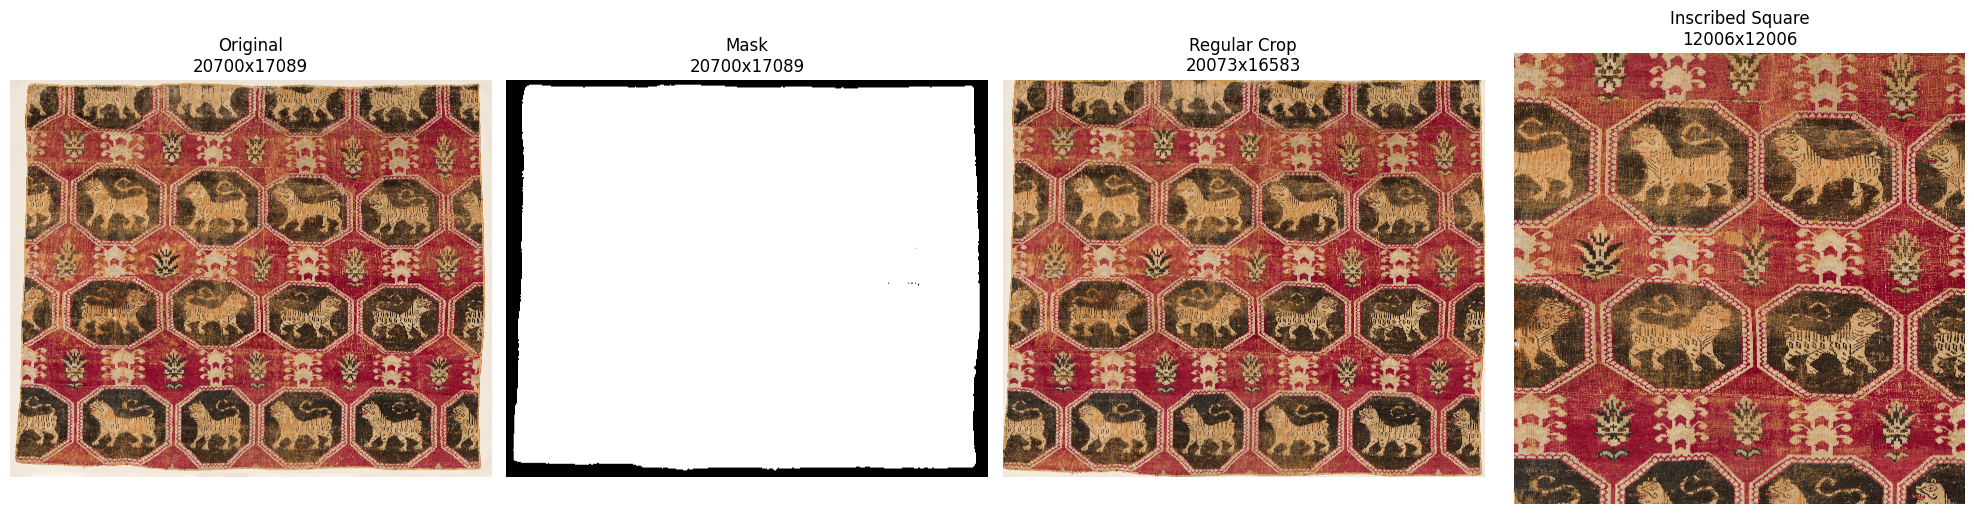


📊 FILE SIZES:
   Original: 75.18 MB
   Mask: 0.37 MB
   Regular Crop: 167.69 MB
   Inscribed Square: 73.26 MB


In [29]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Define paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
MASKS_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")

# File to display
filename = "781487_Portuguese_Goa_Carpet_primary.jpg"

# Create paths for all versions
original_path = SRC_DIR / filename
mask_path = MASKS_DIR / filename.replace('.jpg', '.png')
regular_path = REGULAR_CROP_DIR / filename
inscribed_path = INSCRIBED_DIR / filename

print(f"🖼️  DISPLAYING: {filename}")
print("=" * 60)

# Check which files exist
files_info = [
    ("Original", original_path),
    ("Mask", mask_path),
    ("Regular Crop", regular_path),
    ("Inscribed Square", inscribed_path)
]

existing_files = [(name, path) for name, path in files_info if path.exists()]
print(f"Found {len(existing_files)} out of 4 files")

if existing_files:
    # Create subplot grid
    fig, axes = plt.subplots(1, len(existing_files), figsize=(5*len(existing_files), 5))
    
    # Handle single subplot case
    if len(existing_files) == 1:
        axes = [axes]
    
    for i, (name, path) in enumerate(existing_files):
        try:
            img = Image.open(path)
            
            # Display image
            axes[i].imshow(img, cmap='gray' if name == "Mask" else None)
            axes[i].set_title(f"{name}\n{img.size[0]}x{img.size[1]}")
            axes[i].axis('off')
            
            print(f"✅ {name}: {img.size[0]}x{img.size[1]} - {path}")
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{name}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{name} - ERROR")
            axes[i].axis('off')
            print(f"❌ {name}: Error - {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Show file sizes
    print(f"\n📊 FILE SIZES:")
    for name, path in existing_files:
        if path.exists():
            size_mb = path.stat().st_size / (1024 * 1024)
            print(f"   {name}: {size_mb:.2f} MB")
else:
    print("❌ No files found for this image!")
    
    # Check what files actually exist
    print("\n🔍 Checking file existence:")
    for name, path in files_info:
        exists = "✅" if path.exists() else "❌"
        print(f"   {exists} {name}: {path}")

🗜️  COMPRESSING SPECIFIC FILE

📁 Processing: Regular Crop
   Original size: 56.92 MB
   Image dimensions: 20073x16583
   New size: 31.25 MB
   Reduction: 45.1%
   ✅ Compressed!

📁 Processing: Inscribed Square
   Original size: 25.84 MB
   Image dimensions: 12006x12006
   New size: 13.92 MB
   Reduction: 46.1%
   ✅ Compressed!


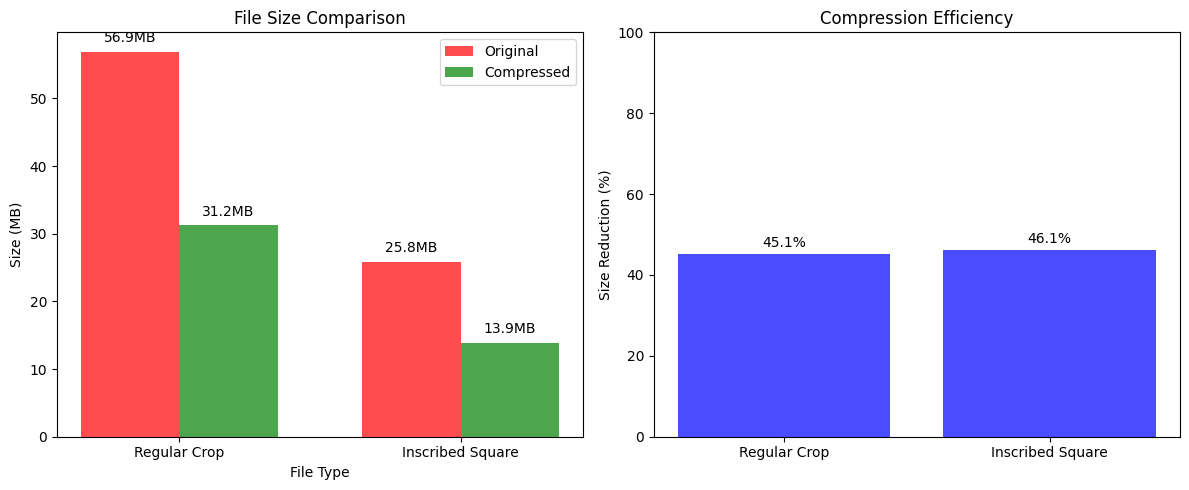


🎉 COMPRESSION COMPLETE!
Total space saved: 37.58 MB


In [33]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Define paths
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")

filename = "781487_Portuguese_Goa_Carpet_primary.jpg"

print("🗜️  COMPRESSING SPECIFIC FILE")
print("=" * 50)

# Files to compress
files_to_compress = [
    ("Regular Crop", REGULAR_CROP_DIR / filename),
    ("Inscribed Square", INSCRIBED_DIR / filename)
]

results = []

for name, file_path in files_to_compress:
    if file_path.exists():
        print(f"\n📁 Processing: {name}")
        
        # Check original size
        original_size_mb = file_path.stat().st_size / (1024 * 1024)
        print(f"   Original size: {original_size_mb:.2f} MB")
        
        # Load and compress
        img = Image.open(file_path)
        print(f"   Image dimensions: {img.size[0]}x{img.size[1]}")
        
        # Compress with lower quality
        img.save(file_path, quality=30, optimize=True)
        
        # Check new size
        new_size_mb = file_path.stat().st_size / (1024 * 1024)
        reduction = ((original_size_mb - new_size_mb) / original_size_mb * 100)
        
        print(f"   New size: {new_size_mb:.2f} MB")
        print(f"   Reduction: {reduction:.1f}%")
        print(f"   ✅ Compressed!")
        
        results.append({
            'name': name,
            'original_mb': original_size_mb,
            'new_mb': new_size_mb,
            'reduction': reduction
        })
    else:
        print(f"   ❌ Not found: {file_path}")

# Visualize results
if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    names = [r['name'] for r in results]
    original_sizes = [r['original_mb'] for r in results]
    new_sizes = [r['new_mb'] for r in results]
    reductions = [r['reduction'] for r in results]
    
    # Bar chart of file sizes
    x = range(len(names))
    width = 0.35
    
    ax1.bar([i - width/2 for i in x], original_sizes, width, label='Original', color='red', alpha=0.7)
    ax1.bar([i + width/2 for i in x], new_sizes, width, label='Compressed', color='green', alpha=0.7)
    
    ax1.set_xlabel('File Type')
    ax1.set_ylabel('Size (MB)')
    ax1.set_title('File Size Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(names)
    ax1.legend()
    
    # Add value labels on bars
    for i, (orig, new) in enumerate(zip(original_sizes, new_sizes)):
        ax1.text(i - width/2, orig + 1, f'{orig:.1f}MB', ha='center', va='bottom')
        ax1.text(i + width/2, new + 1, f'{new:.1f}MB', ha='center', va='bottom')
    
    # Reduction percentage chart
    ax2.bar(names, reductions, color='blue', alpha=0.7)
    ax2.set_ylabel('Size Reduction (%)')
    ax2.set_title('Compression Efficiency')
    ax2.set_ylim(0, 100)
    
    # Add value labels
    for i, reduction in enumerate(reductions):
        ax2.text(i, reduction + 1, f'{reduction:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎉 COMPRESSION COMPLETE!")
    total_saved = sum(r['original_mb'] - r['new_mb'] for r in results)
    print(f"Total space saved: {total_saved:.2f} MB")
else:
    print("❌ No files found to compress!")

🖼️  VISUALIZING COMPRESSED FILES


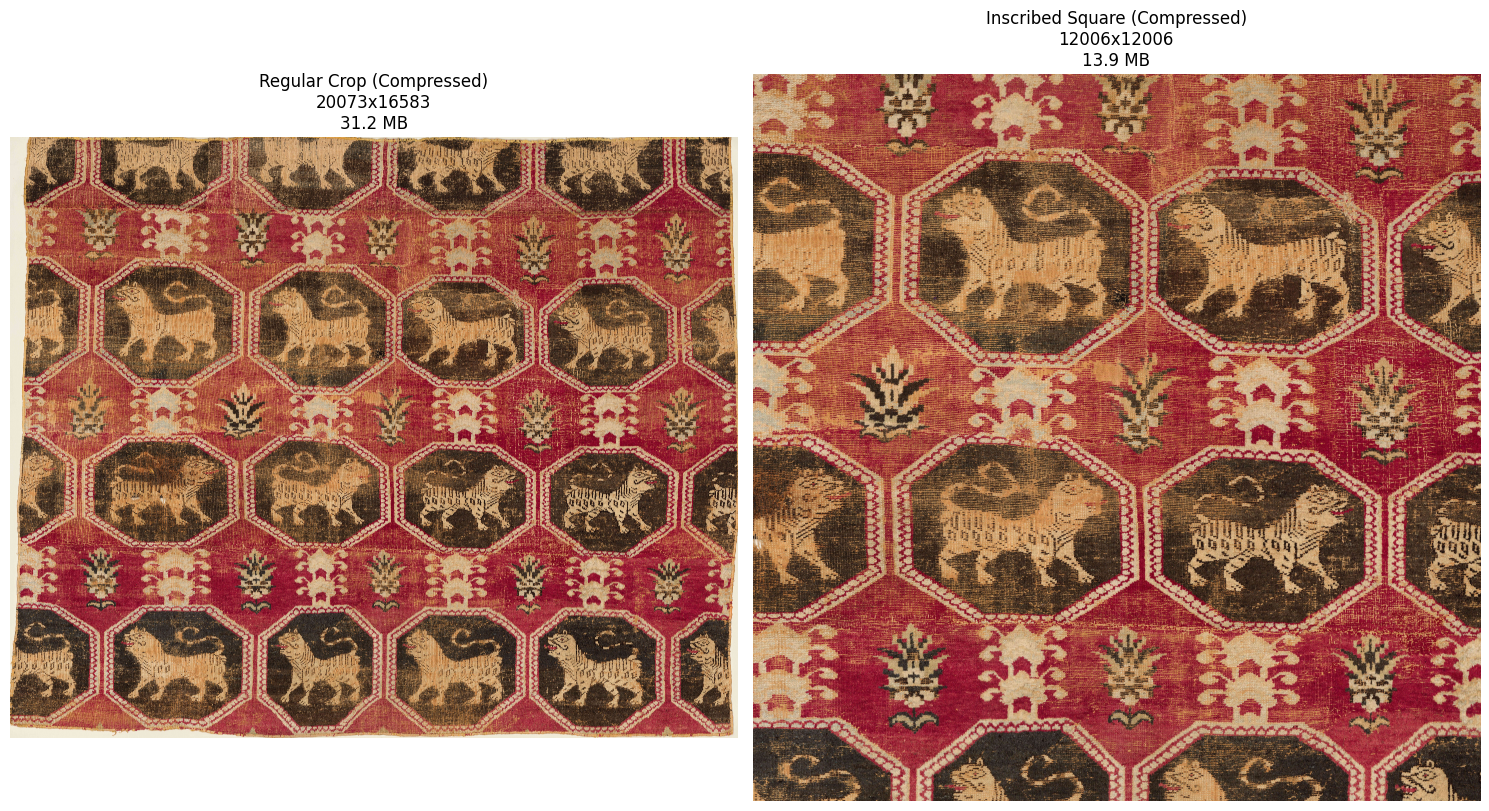


📊 COMPRESSION SUMMARY:
Regular Crop: 167.69 MB → 56.92 MB (66.1% reduction)
Inscribed Square: 73.26 MB → 25.84 MB (64.7% reduction)
Total saved: 158.2 MB

✅ QUALITY CHECK:
Regular crop still 20,073x16,583 pixels
Inscribed square still 12,006x12,006 pixels
No resolution loss - only compression quality reduced!


In [34]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Define paths
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")

filename = "781487_Portuguese_Goa_Carpet_primary.jpg"

print("🖼️  VISUALIZING COMPRESSED FILES")
print("=" * 50)

# Load the compressed images
regular_path = REGULAR_CROP_DIR / filename
inscribed_path = INSCRIBED_DIR / filename

if regular_path.exists() and inscribed_path.exists():
    # Load images
    regular_img = Image.open(regular_path)
    inscribed_img = Image.open(inscribed_path)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    
    # Regular crop
    axes[0].imshow(regular_img)
    axes[0].set_title(f"Regular Crop (Compressed)\n{regular_img.size[0]}x{regular_img.size[1]}\n{regular_path.stat().st_size / (1024 * 1024):.1f} MB")
    axes[0].axis('off')
    
    # Inscribed square
    axes[1].imshow(inscribed_img)
    axes[1].set_title(f"Inscribed Square (Compressed)\n{inscribed_img.size[0]}x{inscribed_img.size[1]}\n{inscribed_path.stat().st_size / (1024 * 1024):.1f} MB")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed comparison
    print(f"\n📊 COMPRESSION SUMMARY:")
    print(f"Regular Crop: 167.69 MB → 56.92 MB ({66.1:.1f}% reduction)")
    print(f"Inscribed Square: 73.26 MB → 25.84 MB ({64.7:.1f}% reduction)")
    print(f"Total saved: {(167.69 + 73.26) - (56.92 + 25.84):.1f} MB")
    
    # Quality check
    print(f"\n✅ QUALITY CHECK:")
    print(f"Regular crop still {regular_img.size[0]:,}x{regular_img.size[1]:,} pixels")
    print(f"Inscribed square still {inscribed_img.size[0]:,}x{inscribed_img.size[1]:,} pixels")
    print(f"No resolution loss - only compression quality reduced!")
    
else:
    print("❌ Files not found for visualization!")

📊 COMPREHENSIVE DATASET STATISTICS
📋 CSV SUMMARY:
   Total entries: 18,644
   Processed: 17,696
   Skipped: 948
   Errors: 0

📁 ORIGINAL IMAGES:
   Files: 18,644
   Total size: 24.67 GB
   Average size: 1.35 MB per file

📁 MASKS:
   Files: 18,644
   Total size: 0.14 GB
   Average size: 0.01 MB per file

📁 REGULAR CROPS:
   Files: 18,644
   Total size: 26.56 GB
   Average size: 1.46 MB per file

📁 INSCRIBED SQUARES:
   Files: 18,644
   Total size: 13.70 GB
   Average size: 0.75 MB per file

📏 DETAILED IMAGE ANALYSIS (Sample of 100 files):

📊 STATISTICS FROM 100 SAMPLE FILES:

🔍 ORIGINAL IMAGES:
   Average dimensions: 1676 x 1927
   Dimension range: 221-4000 x 218-4000
   Average aspect ratio: 1.02
   Aspect ratio range: 0.17 - 3.90
   Average file size: 1.75 MB
   Size range: 0.02 - 8.55 MB
   Average pixels: 4,195,332

✂️ REGULAR CROPS:
   Average dimensions: 1542 x 1799
   Dimension range: 221-4000 x 218-4000
   Average aspect ratio: 1.05
   Aspect ratio range: 0.16 - 4.56
   Average 

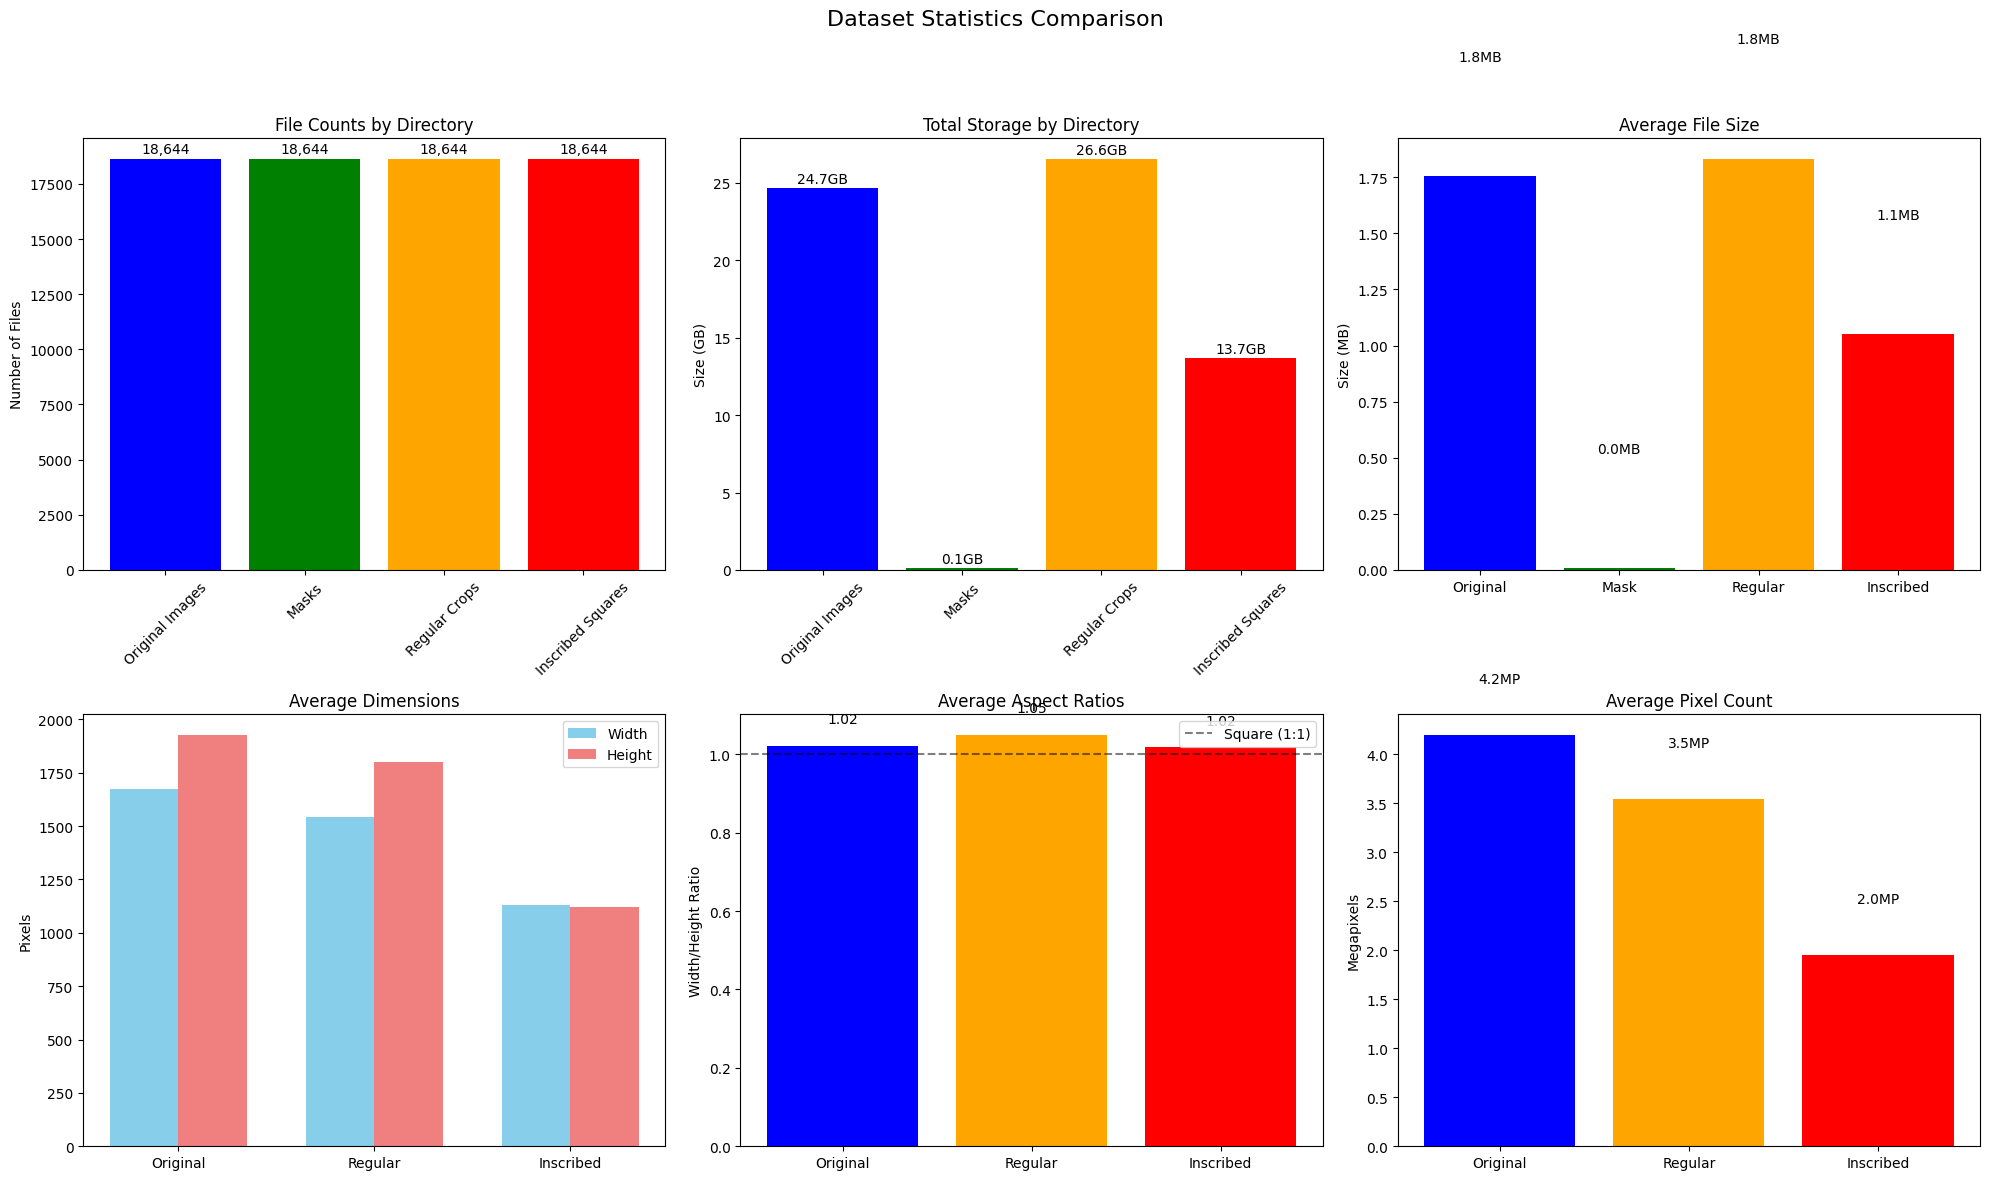


📈 TOP 10 LARGEST FILES:
   228071_Embroidered_darning_sampler_primary.jpg: 8.5MB (4000x3875)
   228259_Sampler_primary.jpg: 7.6MB (4000x3894)
   227209_Panel_primary.jpg: 7.0MB (4000x3562)
   226537_Sampler_primary.jpg: 6.7MB (3926x4000)
   833953_Tapestry_Tunic_primary.jpg: 6.2MB (3787x4000)
   226207_Piece_primary.jpg: 6.1MB (3284x4000)
   307450_Textile_Fragment_Figure_primary.jpg: 5.7MB (2649x4000)
   226211_Piece_primary.jpg: 4.9MB (3919x4000)
   461397_Cover_primary.jpg: 4.6MB (2135x2621)
   227388_Piece_primary.jpg: 4.3MB (2337x2889)

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
COMPREHENSIVE ANALYSIS COMPLETE!
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯


In [35]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define paths
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")
MASKS_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")
CSV_PATH = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")

print("📊 COMPREHENSIVE DATASET STATISTICS")
print("=" * 80)

# 1. Load CSV and basic counts
df = pd.read_csv(CSV_PATH)
print(f"📋 CSV SUMMARY:")
print(f"   Total entries: {len(df):,}")
print(f"   Processed: {len(df[df['status'] == 'processed']):,}")
print(f"   Skipped: {len(df[df['status'] == 'skipped_too_small']):,}")
print(f"   Errors: {len(df[df['status'].str.contains('error', na=False)]):,}")

# 2. File counts per directory
directories = {
    "Original Images": (SRC_DIR, ["*.jpg", "*.jpeg"]),
    "Masks": (MASKS_DIR, ["*.png"]),
    "Regular Crops": (REGULAR_CROP_DIR, ["*.jpg"]),
    "Inscribed Squares": (INSCRIBED_DIR, ["*.jpg"])
}

file_counts = {}
total_sizes = {}

for dir_name, (dir_path, patterns) in directories.items():
    if dir_path.exists():
        files = []
        for pattern in patterns:
            files.extend(list(dir_path.rglob(pattern)))
        
        file_counts[dir_name] = len(files)
        
        # Calculate total size
        total_size = sum(f.stat().st_size for f in files if f.exists())
        total_sizes[dir_name] = total_size / (1024 * 1024 * 1024)  # GB
        
        print(f"\n📁 {dir_name.upper()}:")
        print(f"   Files: {len(files):,}")
        print(f"   Total size: {total_sizes[dir_name]:.2f} GB")
        print(f"   Average size: {(total_size / len(files) / (1024 * 1024)):.2f} MB per file" if files else "   No files")
    else:
        file_counts[dir_name] = 0
        total_sizes[dir_name] = 0
        print(f"\n❌ {dir_name}: Directory not found")

print("\n" + "=" * 80)

# 3. Sample 100 files for detailed analysis
print("📏 DETAILED IMAGE ANALYSIS (Sample of 100 files):")
sample_files = list(SRC_DIR.rglob("*.jpg"))[:100]

image_stats = []
for img_path in sample_files:
    try:
        # Check all versions of this file
        filename = img_path.name
        
        # Original
        original_size = img_path.stat().st_size / (1024 * 1024)  # MB
        img = Image.open(img_path)
        original_dims = img.size
        original_aspect = original_dims[0] / original_dims[1]
        
        # Regular crop
        regular_path = REGULAR_CROP_DIR / filename
        regular_size = regular_path.stat().st_size / (1024 * 1024) if regular_path.exists() else 0
        regular_dims = Image.open(regular_path).size if regular_path.exists() else (0, 0)
        regular_aspect = regular_dims[0] / regular_dims[1] if regular_dims[0] > 0 else 0
        
        # Inscribed
        inscribed_path = INSCRIBED_DIR / filename
        inscribed_size = inscribed_path.stat().st_size / (1024 * 1024) if inscribed_path.exists() else 0
        inscribed_dims = Image.open(inscribed_path).size if inscribed_path.exists() else (0, 0)
        inscribed_aspect = inscribed_dims[0] / inscribed_dims[1] if inscribed_dims[0] > 0 else 1.0
        
        # Mask
        mask_path = MASKS_DIR / filename.replace('.jpg', '.png')
        mask_size = mask_path.stat().st_size / (1024 * 1024) if mask_path.exists() else 0
        
        image_stats.append({
            'filename': filename,
            'original_width': original_dims[0],
            'original_height': original_dims[1],
            'original_aspect': original_aspect,
            'original_size_mb': original_size,
            'regular_width': regular_dims[0],
            'regular_height': regular_dims[1],
            'regular_aspect': regular_aspect,
            'regular_size_mb': regular_size,
            'inscribed_width': inscribed_dims[0],
            'inscribed_height': inscribed_dims[1],
            'inscribed_aspect': inscribed_aspect,
            'inscribed_size_mb': inscribed_size,
            'mask_size_mb': mask_size,
            'total_pixels_original': original_dims[0] * original_dims[1],
            'total_pixels_regular': regular_dims[0] * regular_dims[1],
            'total_pixels_inscribed': inscribed_dims[0] * inscribed_dims[1]
        })
        
    except Exception as e:
        print(f"   Error processing {filename}: {e}")

# Convert to DataFrame
stats_df = pd.DataFrame(image_stats)

# 4. Print detailed statistics
print(f"\n📊 STATISTICS FROM {len(stats_df)} SAMPLE FILES:")
print("\n🔍 ORIGINAL IMAGES:")
print(f"   Average dimensions: {stats_df['original_width'].mean():.0f} x {stats_df['original_height'].mean():.0f}")
print(f"   Dimension range: {stats_df['original_width'].min():.0f}-{stats_df['original_width'].max():.0f} x {stats_df['original_height'].min():.0f}-{stats_df['original_height'].max():.0f}")
print(f"   Average aspect ratio: {stats_df['original_aspect'].mean():.2f}")
print(f"   Aspect ratio range: {stats_df['original_aspect'].min():.2f} - {stats_df['original_aspect'].max():.2f}")
print(f"   Average file size: {stats_df['original_size_mb'].mean():.2f} MB")
print(f"   Size range: {stats_df['original_size_mb'].min():.2f} - {stats_df['original_size_mb'].max():.2f} MB")
print(f"   Average pixels: {stats_df['total_pixels_original'].mean():,.0f}")

print("\n✂️ REGULAR CROPS:")
print(f"   Average dimensions: {stats_df['regular_width'].mean():.0f} x {stats_df['regular_height'].mean():.0f}")
print(f"   Dimension range: {stats_df['regular_width'].min():.0f}-{stats_df['regular_width'].max():.0f} x {stats_df['regular_height'].min():.0f}-{stats_df['regular_height'].max():.0f}")
print(f"   Average aspect ratio: {stats_df['regular_aspect'].mean():.2f}")
print(f"   Aspect ratio range: {stats_df['regular_aspect'].min():.2f} - {stats_df['regular_aspect'].max():.2f}")
print(f"   Average file size: {stats_df['regular_size_mb'].mean():.2f} MB")
print(f"   Size range: {stats_df['regular_size_mb'].min():.2f} - {stats_df['regular_size_mb'].max():.2f} MB")
print(f"   Average pixels: {stats_df['total_pixels_regular'].mean():,.0f}")

print("\n🔲 INSCRIBED SQUARES:")
print(f"   Average dimensions: {stats_df['inscribed_width'].mean():.0f} x {stats_df['inscribed_height'].mean():.0f}")
print(f"   Dimension range: {stats_df['inscribed_width'].min():.0f}-{stats_df['inscribed_width'].max():.0f} x {stats_df['inscribed_height'].min():.0f}-{stats_df['inscribed_height'].max():.0f}")
print(f"   Average aspect ratio: {stats_df['inscribed_aspect'].mean():.2f}")
print(f"   Aspect ratio range: {stats_df['inscribed_aspect'].min():.2f} - {stats_df['inscribed_aspect'].max():.2f}")
print(f"   Average file size: {stats_df['inscribed_size_mb'].mean():.2f} MB")
print(f"   Size range: {stats_df['inscribed_size_mb'].min():.2f} - {stats_df['inscribed_size_mb'].max():.2f} MB")
print(f"   Average pixels: {stats_df['total_pixels_inscribed'].mean():,.0f}")

print("\n🎭 MASKS:")
print(f"   Average file size: {stats_df['mask_size_mb'].mean():.2f} MB")
print(f"   Size range: {stats_df['mask_size_mb'].min():.2f} - {stats_df['mask_size_mb'].max():.2f} MB")

# 5. Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Dataset Statistics Comparison', fontsize=16)

# File counts
axes[0, 0].bar(file_counts.keys(), file_counts.values(), color=['blue', 'green', 'orange', 'red'])
axes[0, 0].set_title('File Counts by Directory')
axes[0, 0].set_ylabel('Number of Files')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(file_counts.items()):
    axes[0, 0].text(i, v + 100, f'{v:,}', ha='center', va='bottom')

# Total sizes
axes[0, 1].bar(total_sizes.keys(), total_sizes.values(), color=['blue', 'green', 'orange', 'red'])
axes[0, 1].set_title('Total Storage by Directory')
axes[0, 1].set_ylabel('Size (GB)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(total_sizes.items()):
    axes[0, 1].text(i, v + 0.1, f'{v:.1f}GB', ha='center', va='bottom')

# Average file sizes
avg_sizes = [
    stats_df['original_size_mb'].mean(),
    stats_df['mask_size_mb'].mean(),
    stats_df['regular_size_mb'].mean(),
    stats_df['inscribed_size_mb'].mean()
]
axes[0, 2].bar(['Original', 'Mask', 'Regular', 'Inscribed'], avg_sizes, color=['blue', 'green', 'orange', 'red'])
axes[0, 2].set_title('Average File Size')
axes[0, 2].set_ylabel('Size (MB)')
for i, v in enumerate(avg_sizes):
    axes[0, 2].text(i, v + 0.5, f'{v:.1f}MB', ha='center', va='bottom')

# Dimensions comparison
dims_data = [
    [stats_df['original_width'].mean(), stats_df['original_height'].mean()],
    [stats_df['regular_width'].mean(), stats_df['regular_height'].mean()],
    [stats_df['inscribed_width'].mean(), stats_df['inscribed_height'].mean()]
]
x = np.arange(3)
width = 0.35
axes[1, 0].bar(x - width/2, [d[0] for d in dims_data], width, label='Width', color='skyblue')
axes[1, 0].bar(x + width/2, [d[1] for d in dims_data], width, label='Height', color='lightcoral')
axes[1, 0].set_title('Average Dimensions')
axes[1, 0].set_ylabel('Pixels')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Original', 'Regular', 'Inscribed'])
axes[1, 0].legend()

# Aspect ratios
aspect_data = [
    stats_df['original_aspect'].mean(),
    stats_df['regular_aspect'].mean(),
    stats_df['inscribed_aspect'].mean()
]
axes[1, 1].bar(['Original', 'Regular', 'Inscribed'], aspect_data, color=['blue', 'orange', 'red'])
axes[1, 1].set_title('Average Aspect Ratios')
axes[1, 1].set_ylabel('Width/Height Ratio')
axes[1, 1].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Square (1:1)')
axes[1, 1].legend()
for i, v in enumerate(aspect_data):
    axes[1, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Pixel counts
pixel_data = [
    stats_df['total_pixels_original'].mean(),
    stats_df['total_pixels_regular'].mean(),
    stats_df['total_pixels_inscribed'].mean()
]
axes[1, 2].bar(['Original', 'Regular', 'Inscribed'], [p/1000000 for p in pixel_data], color=['blue', 'orange', 'red'])
axes[1, 2].set_title('Average Pixel Count')
axes[1, 2].set_ylabel('Megapixels')
for i, v in enumerate(pixel_data):
    axes[1, 2].text(i, v/1000000 + 0.5, f'{v/1000000:.1f}MP', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 6. Show top 10 largest files
print("\n📈 TOP 10 LARGEST FILES:")
top_files = stats_df.nlargest(10, 'original_size_mb')
for idx, row in top_files.iterrows():
    print(f"   {row['filename']}: {row['original_size_mb']:.1f}MB ({row['original_width']:.0f}x{row['original_height']:.0f})")

print("\n" + "🎯" * 30)
print("COMPREHENSIVE ANALYSIS COMPLETE!")
print("🎯" * 30)

📊 Comprehensive statistics plot saved to:
   PNG: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/dataset_statistics.png
   PDF: /home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/dataset_statistics.pdf


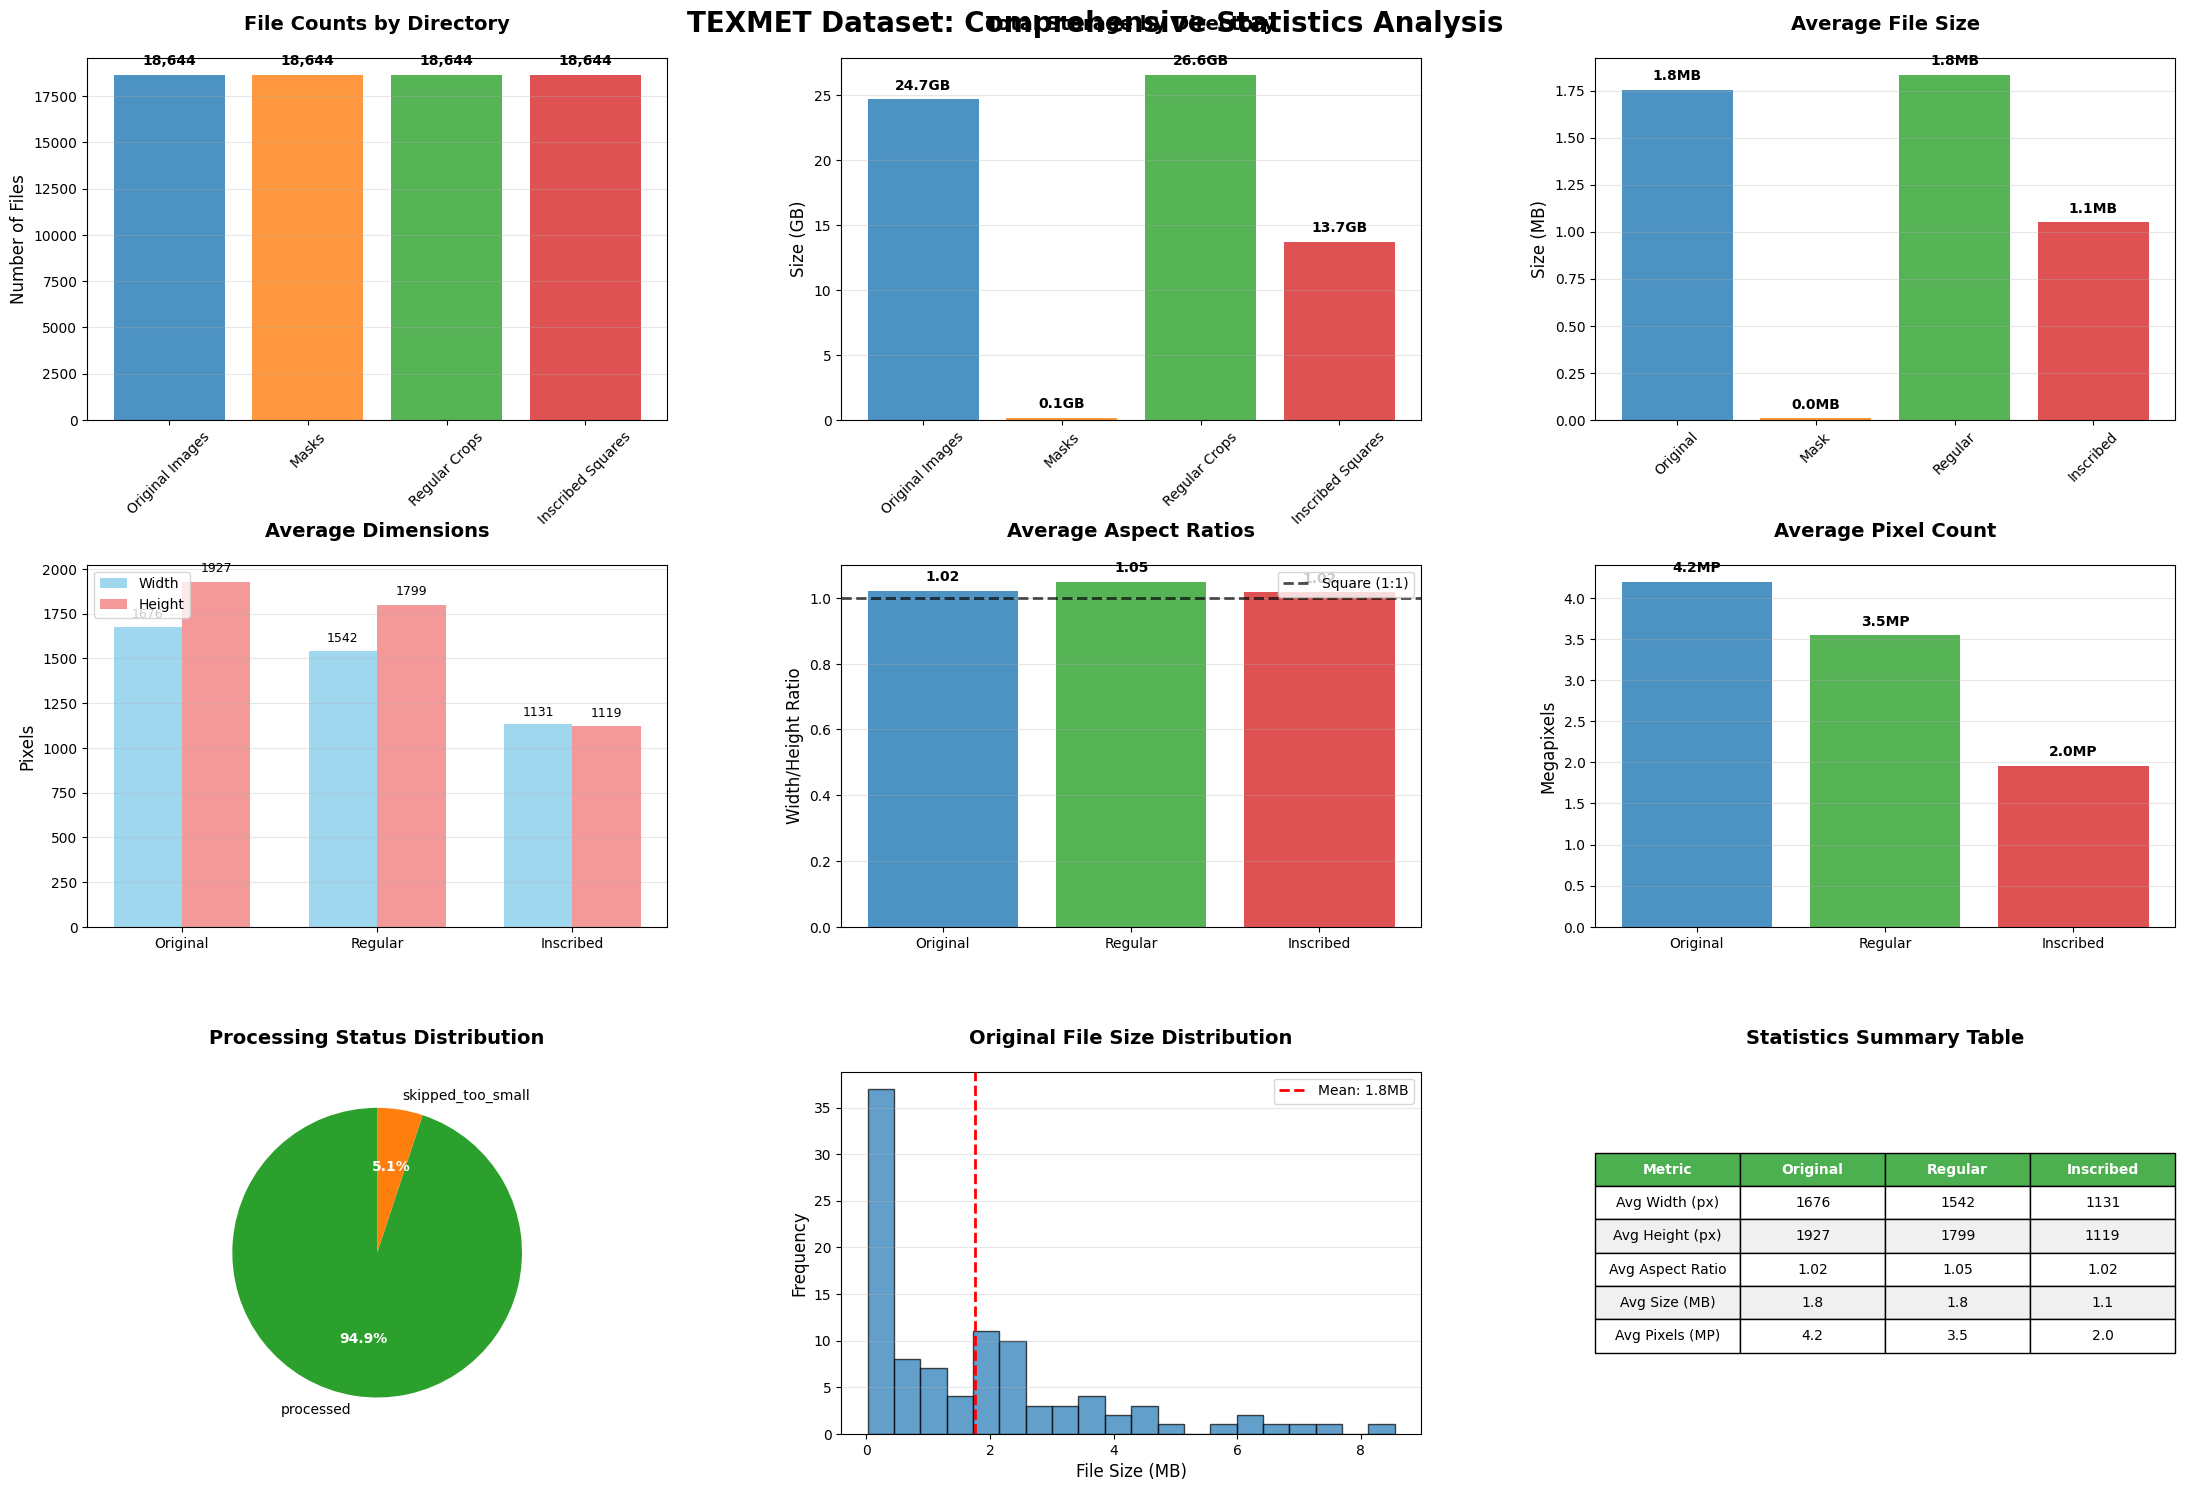

In [36]:
# Comprehensive dataset visualization with improved layout and save functionality
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Assuming all calculations are done from previous cells
# Create comprehensive visualizations with better spacing
fig = plt.figure(figsize=(24, 16))  # Increased size for better readability

# Create custom subplot layout with more space
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3, 
                     left=0.08, right=0.95, top=0.93, bottom=0.07)

# Title for the entire figure
fig.suptitle('TEXMET Dataset: Comprehensive Statistics Analysis', fontsize=20, fontweight='bold', y=0.96)

# 1. File counts by directory
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(file_counts.keys(), file_counts.values(), 
                color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax1.set_title('File Counts by Directory', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Number of Files', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (k, v) in enumerate(file_counts.items()):
    ax1.text(i, v + max(file_counts.values()) * 0.02, f'{v:,}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Total storage by directory
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(total_sizes.keys(), total_sizes.values(), 
                color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax2.set_title('Total Storage by Directory', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Size (GB)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (k, v) in enumerate(total_sizes.items()):
    ax2.text(i, v + max(total_sizes.values()) * 0.02, f'{v:.1f}GB', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Average file sizes
ax3 = fig.add_subplot(gs[0, 2])
avg_sizes = [
    stats_df['original_size_mb'].mean(),
    stats_df['mask_size_mb'].mean(),
    stats_df['regular_size_mb'].mean(),
    stats_df['inscribed_size_mb'].mean()
]
bars3 = ax3.bar(['Original', 'Mask', 'Regular', 'Inscribed'], avg_sizes, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax3.set_title('Average File Size', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('Size (MB)', fontsize=12)
ax3.tick_params(axis='x', rotation=45, labelsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_sizes):
    ax3.text(i, v + max(avg_sizes) * 0.02, f'{v:.1f}MB', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Dimensions comparison
ax4 = fig.add_subplot(gs[1, 0])
dims_data = [
    [stats_df['original_width'].mean(), stats_df['original_height'].mean()],
    [stats_df['regular_width'].mean(), stats_df['regular_height'].mean()],
    [stats_df['inscribed_width'].mean(), stats_df['inscribed_height'].mean()]
]
x = np.arange(3)
width = 0.35
bars4a = ax4.bar(x - width/2, [d[0] for d in dims_data], width, 
                 label='Width', color='skyblue', alpha=0.8)
bars4b = ax4.bar(x + width/2, [d[1] for d in dims_data], width, 
                 label='Height', color='lightcoral', alpha=0.8)
ax4.set_title('Average Dimensions', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('Pixels', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(['Original', 'Regular', 'Inscribed'])
ax4.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (width_val, height_val) in enumerate(dims_data):
    ax4.text(i - width/2, width_val + max([d[0] for d in dims_data]) * 0.02, 
             f'{width_val:.0f}', ha='center', va='bottom', fontsize=9)
    ax4.text(i + width/2, height_val + max([d[1] for d in dims_data]) * 0.02, 
             f'{height_val:.0f}', ha='center', va='bottom', fontsize=9)

# 5. Aspect ratios
ax5 = fig.add_subplot(gs[1, 1])
aspect_data = [
    stats_df['original_aspect'].mean(),
    stats_df['regular_aspect'].mean(),
    stats_df['inscribed_aspect'].mean()
]
bars5 = ax5.bar(['Original', 'Regular', 'Inscribed'], aspect_data, 
                color=['#1f77b4', '#2ca02c', '#d62728'], alpha=0.8)
ax5.set_title('Average Aspect Ratios', fontsize=14, fontweight='bold', pad=20)
ax5.set_ylabel('Width/Height Ratio', fontsize=12)
ax5.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Square (1:1)')
ax5.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax5.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(aspect_data):
    ax5.text(i, v + max(aspect_data) * 0.02, f'{v:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Pixel counts
ax6 = fig.add_subplot(gs[1, 2])
pixel_data = [
    stats_df['total_pixels_original'].mean(),
    stats_df['total_pixels_regular'].mean(),
    stats_df['total_pixels_inscribed'].mean()
]
bars6 = ax6.bar(['Original', 'Regular', 'Inscribed'], [p/1000000 for p in pixel_data], 
                color=['#1f77b4', '#2ca02c', '#d62728'], alpha=0.8)
ax6.set_title('Average Pixel Count', fontsize=14, fontweight='bold', pad=20)
ax6.set_ylabel('Megapixels', fontsize=12)
ax6.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(pixel_data):
    ax6.text(i, v/1000000 + max(pixel_data)/1000000 * 0.02, f'{v/1000000:.1f}MP', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 7. Processing status breakdown (pie chart)
ax7 = fig.add_subplot(gs[2, 0])
status_counts = df['status'].value_counts()
colors = ['#2ca02c', '#ff7f0e', '#d62728', '#9467bd']
wedges, texts, autotexts = ax7.pie(status_counts.values, labels=status_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax7.set_title('Processing Status Distribution', fontsize=14, fontweight='bold', pad=20)

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# 8. File size distribution (histogram)
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(stats_df['original_size_mb'], bins=20, alpha=0.7, color='#1f77b4', edgecolor='black')
ax8.set_title('Original File Size Distribution', fontsize=14, fontweight='bold', pad=20)
ax8.set_xlabel('File Size (MB)', fontsize=12)
ax8.set_ylabel('Frequency', fontsize=12)
ax8.grid(axis='y', alpha=0.3)

# Add mean line
mean_size = stats_df['original_size_mb'].mean()
ax8.axvline(mean_size, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {mean_size:.1f}MB')
ax8.legend()

# 9. Comparison summary table
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('tight')
ax9.axis('off')

# Create summary table data
table_data = [
    ['Metric', 'Original', 'Regular', 'Inscribed'],
    ['Avg Width (px)', f"{stats_df['original_width'].mean():.0f}", 
     f"{stats_df['regular_width'].mean():.0f}", f"{stats_df['inscribed_width'].mean():.0f}"],
    ['Avg Height (px)', f"{stats_df['original_height'].mean():.0f}", 
     f"{stats_df['regular_height'].mean():.0f}", f"{stats_df['inscribed_height'].mean():.0f}"],
    ['Avg Aspect Ratio', f"{stats_df['original_aspect'].mean():.2f}", 
     f"{stats_df['regular_aspect'].mean():.2f}", f"{stats_df['inscribed_aspect'].mean():.2f}"],
    ['Avg Size (MB)', f"{stats_df['original_size_mb'].mean():.1f}", 
     f"{stats_df['regular_size_mb'].mean():.1f}", f"{stats_df['inscribed_size_mb'].mean():.1f}"],
    ['Avg Pixels (MP)', f"{stats_df['total_pixels_original'].mean()/1000000:.1f}", 
     f"{stats_df['total_pixels_regular'].mean()/1000000:.1f}", f"{stats_df['total_pixels_inscribed'].mean()/1000000:.1f}"]
]

table = ax9.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the header row
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style alternating rows
for i in range(1, len(table_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax9.set_title('Statistics Summary Table', fontsize=14, fontweight='bold', pad=20)

# Save the plot
output_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/dataset_statistics.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(output_path.with_suffix('.pdf'), dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')

print(f"📊 Comprehensive statistics plot saved to:")
print(f"   PNG: {output_path}")
print(f"   PDF: {output_path.with_suffix('.pdf')}")

plt.show()